# **ISAAKx: *I*nterestingness-based *S*emi-*A*utom*A*tic *K*nowledge E*X*pansion**

In the previous notebook we have built a narrative graph featuring Wikipedia entities and DBpedia- as well as CIDOC-CRM relationships harnessing "Six Degrees of Wikipedia" (*HILDEGARD*).

In the following, we are using it as input of our new workflow, **ISAAKx**, which will output an enriched Narrative Knowledge Graph, ready to be exploited for the next module of the narrative generation pipeline.

As pointed out in the title, the enrichment is Interestingness-based. Interesting relationships and entities will be extracted in a principled way, taking in consideration their relevance for the final text generation.

To this extent, "interesting" is in this context defined as *narratively* interesting.

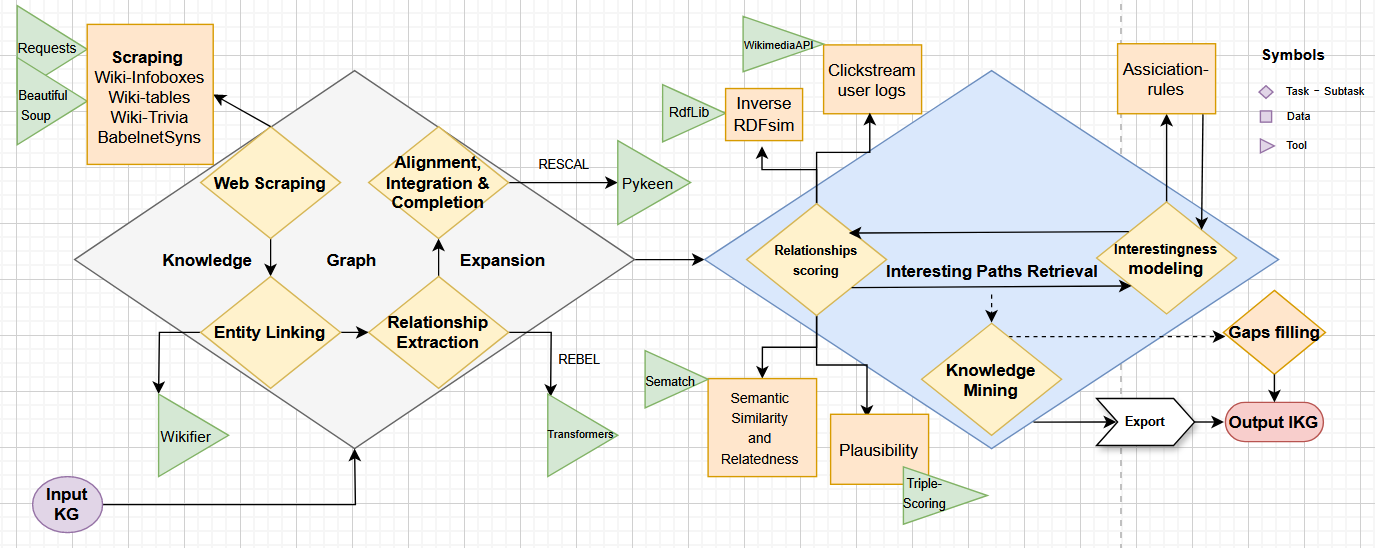

For referencing this work in scientific publications:

*Palma, C. (2024). Modelling interestingness: A workflow for surprisal-based knowledge mining in narrative semantic networks. In ESWC 2024 Workshops and Tutorials Joint Proceedings (Vol. 3749, pp. 1–10). CEUR-WS.*

*Download Packages*

In [1]:
!pip install kuzu
!pip install pandas
!pip install requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 55.1 MB/s eta 0:00:00


In [2]:
!pip install pyvis networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.0 MB/s eta 0:00:00


# KNOWLEDGE GRAPH EXPANSION

# *Processing HILDEGARD output to adapt its format for the KUZU knowledge base*

In [3]:
import pandas as pd

# Input and output file paths
input_file = "/content/merged_knowledge_graph_triples.csv"  # Replace with your actual input file path
entity_output_file = "/content/entity_table.csv"
relationship_output_file = "/content/relationships_table.csv"

# Load the CSV file
df = pd.read_csv(input_file)

# Ensure the input file has the correct headers
required_headers = {"subject", "predicate", "object"}
if not required_headers.issubset(df.columns):
    raise ValueError(f"The input file must have the following headers: {required_headers}")

# Create the entity table (unique entities from "subject" and "object")
entities = pd.DataFrame({"uri": pd.concat([df["subject"], df["object"]]).drop_duplicates()})
entities.to_csv(entity_output_file, index=False)
print(f"Entity table saved to {entity_output_file}")

# Create the relationships table
relationships = df[["subject", "object", "predicate"]].rename(columns={"subject": "FROM", "object": "TO", "predicate": "name"})
relationships.to_csv(relationship_output_file, index=False)
print(f"Relationships table saved to {relationship_output_file}")


Entity table saved to /content/entity_table.csv
Relationships table saved to /content/relationships_table.csv


It creates the initial KUZU schema for storing the input Knowledge Graph

In [4]:
import kuzu
import csv
import shutil
import os
import pandas as pd

database_path = "knowledge_graph_db"

if os.path.exists(database_path):
    shutil.rmtree(database_path)
    print(f"Database directory '{database_path}' deleted.")

# Re-initialize the Kuzu database
db = kuzu.Database(database_path)
conn = kuzu.Connection(db)

# Step 2: Create the schema for entities and relationships without additional attributes
try:
    # Define node type for entities
    conn.execute("""
    CREATE NODE TABLE Entity (
        uri STRING,
        PRIMARY KEY (uri)
    )
    """)

    # Define a basic relationship type without additional attributes
    conn.execute("""
    CREATE REL TABLE RELATIONSHIP (FROM Entity TO Entity, name string)
     """)


    print("Schema created successfully.")
except Exception as e:
    print(f"Error creating schema: {e}")


Schema created successfully.


# *Input Knowledge Graph in csv format*  
It takes output from Hildegard and load into the KUZU database.

In [5]:
def insert_triple(conn, ent_path, rel_path):
    try:
        # Copy data into the Entity node table
        conn.execute(f'COPY Entity FROM "{ent_path}" (header=True, IGNORE_ERRORS=True)')
        print(f"Data successfully inserted into Entity from {ent_path}.")

        # Copy data into the RELATIONSHIP table
        conn.execute(f'COPY RELATIONSHIP FROM "{rel_path}" (header=True, IGNORE_ERRORS=True)')
        print(f"Data successfully inserted into RELATIONSHIP from {rel_path}.")

    except Exception as e:
        print(f"Error during data insertion: {e}")

    # Execute a query to verify the inserted data
    print("\nQuerying the data to verify insertion...")
    response = conn.execute(
        """
        MATCH (a:Entity)-[r:RELATIONSHIP]->(b:Entity)
        RETURN a.uri AS Subject, r.name AS Predicate, b.uri AS Object
        """
    )
    triples = []
    while response.has_next():
        print(response.get_next())
        triples.append(response.get_next())
    pandatriple = pd.DataFrame(triples, columns=['subject', 'predicate', 'object'])
    return pandatriple


ent_path = '/content/entity_table.csv'
rel_path = '/content/relationships_table.csv'

df_triples = insert_triple(conn, ent_path, rel_path)
print("Data successfully uploaded to Kuzu database.")



# Step 2: Save triples to a TSV file
def save_triples_to_tsv(df, output_path):
    df.to_csv(output_path, sep='\t', index=False, header=False)
    print(f"Triples saved to {output_path}")

# Extract triples and save to TSV

triples_path = '/content/kuzu_triples.tsv'
save_triples_to_tsv(df_triples, triples_path)

Data successfully inserted into Entity from /content/entity_table.csv.
Data successfully inserted into RELATIONSHIP from /content/relationships_table.csv.

Querying the data to verify insertion...
['http://dbpedia.org/resource/House_of_Representatives_(Egypt)', 'http://dbpedia.org/ontology/location', 'http://dbpedia.org/resource/Egypt']
['http://dbpedia.org/resource/Late_Period_of_ancient_Egypt', 'http://dbpedia.org/ontology/capital', 'http://dbpedia.org/resource/Sais,_Egypt']
['http://dbpedia.org/resource/Late_Period_of_ancient_Egypt', 'http://dbpedia.org/property/capital', 'http://dbpedia.org/resource/Sebennytos']
['http://dbpedia.org/resource/Late_Period_of_ancient_Egypt', 'http://dbpedia.org/property/capital', 'http://dbpedia.org/resource/Sais,_Egypt']
['Hellenistic period', 'P102', 'https://en.wikipedia.org/wiki/Hellenistic_period']
['Hellenistic period', 'P104', 'Period of Mediterranean history from 323 to 31 BC']
['http://dbpedia.org/resource/Antalya', 'http://dbpedia.org/proper

# *Knowledge Graph Visualization*

It export an *.html* file providing a visualization of the uploaded Knowledge base.

In [6]:
from kuzu import Database, Connection
import networkx as nx
from pyvis.network import Network

def load_graph_from_kuzu(database_path: str, query: str):
    """
    Loads graph data from a Kuzu database using a query.

    Args:
        db_path (str): Path to the Kuzu database.
        query (str): Query to extract graph data (e.g., MATCH queries).

    Returns:
        nx.Graph: A NetworkX graph representing the data.
    """

    db = Database(database_path)
    conn = Connection(db)

    # Run the query
    results = conn.execute(query)

    # Extract nodes and edges
    graph = nx.DiGraph()  # Create a directed graph (use Graph() for undirected)
    while results.has_next():
        result = results.get_next()
        source = result[0]  # Source node
        target = result[1]  # Target node
        label = result[2] if len(result) > 2 else None  # Optional edge label

        if source is not None and target is not None:  # Added this check
            # Add nodes and edge to the graph
            graph.add_node(source)
            graph.add_node(target)
            graph.add_edge(source, target, label=label)


    return graph


def visualize_graph(graph: nx.Graph, output_file: str = "graph.html"):
    """
    Visualizes a NetworkX graph using PyViz and saves it to an HTML file.

    Args:
        graph (nx.Graph): The NetworkX graph to visualize.
        output_file (str): Path to save the visualization HTML file.
    """
    # Create a PyViz network
    net = Network(notebook=True, directed=True)

    # Add nodes and edges from the NetworkX graph
    for node in graph.nodes:
        net.add_node(node, label=str(node))

    for source, target, data in graph.edges(data=True):
        label = data.get('label', '')
        net.add_edge(source, target, title=label)

    # Generate and save visualization
    net.show(output_file)
    print(f"Graph visualization saved to {output_file}")


query = "MATCH (a)-[r]->(b) RETURN a.uri, b.uri, r.name"  # Example query
graph = load_graph_from_kuzu(database_path, query)
visualize_graph(graph, "kuzu_graph3.html")


kuzu_graph3.html
Graph visualization saved to kuzu_graph3.html


### **Relationships generation and extraction**

In [7]:
!pip install wptools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 34.7 MB/s eta 0:00:00
  Created wheel for html2text: filename=html2text-2024.2.26-py3-none-any.whl size=33111 sha256=57dd2901e6df0ee1bed1c35afb0ba23640ac1448dfd132ebda8d3fe0ef8b8b05
  Stored in directory: /root/.cache/pip/wheels/f3/96/6d/a7eba8f80d31cbd188a2787b81514d82fc5ae6943c44777659
Successfully built html2text


In [ ]:
!pip install transformers


# *Connect entities to their Wikipedia Infobox*

In [ ]:
import kuzu
import requests
from typing import List, Dict
import wptools
#from transformers import AutoModelForCausalLM, AutoTokenizer
import shutil
import os
import kuzu

database_path = 'knowledge_graph_db'  # Path to your Kuzu database

db = kuzu.Database(database_path)
conn = kuzu.Connection(db)

# Wikipedia API base URL
WIKIPEDIA_API_URL = "https://en.wikipedia.org/w/api.php"

try:
    conn.execute("""
    CREATE NODE TABLE IF NOT EXISTS Infobox(
        page STRING,
        PRIMARY KEY (page)
    )
    """)
except Exception as e:
    print(f"Error creating schema: {e}")

try:
    conn.execute("""
    CREATE REL TABLE IF NOT EXISTS HAS_INFOBOX (FROM Entity TO Infobox, value string)
    """)
except Exception as e:
    print(f"Error creating schema: {e}")

try:
    conn.execute("""
          CREATE NODE TABLE IF NOT EXISTS InfoboxParam (
              content STRING,
              PRIMARY KEY (content)
          );
      """)
    print("Schema for Infobox created successfully.")

except Exception as e:
    print(f"Error creating schema: {e}")

def get_entities_from_kuzu() -> List[str]:
    """Fetch all entities (URIs) from the Kuzu Entity table."""
    query = "MATCH (e:Entity) RETURN e.uri;"
    result = conn.execute(query)
    entities = []
    # Iterate over the query result using result.get_next()
    while result.has_next():
        row = result.get_next()
        entities.append(row[0])
    # Exclude placeholder or invalid values
    return [entity for entity in entities if entity.lower() not in {'subject', 'predicate', 'object'}]

def search_wikipedia(entity: str) -> str:
    """Search for an entity on Wikipedia and return the page title."""
    if entity.startswith("http://dbpedia.org/resource/"):
        entity = entity.replace("http://dbpedia.org/resource/", "").replace("_", " ")
        print(f"  Processed DBpedia link to entity name: {entity}")
    elif entity.startswith("http://www.wikidata.org/entity/"):
        entity = entity.replace("http://www.wikidata.org/entity/", "").replace("_", " ")
        print(f"  Processed Wikidata link to entity name: {entity}")
    elif entity.startswith("https://en.wikipedia.org/wiki/"):
        entity = entity.replace("https://en.wikipedia.org/wiki/", "").replace("_", " ")
        print(f"  Processed Wikipedia link to entity name: {entity}")

    params = {
        "action": "query",
        "list": "search",
        "srsearch": entity,
        "format": "json",
    }
    response = requests.get(WIKIPEDIA_API_URL, params=params)
    response.raise_for_status()
    search_results = response.json()
    if search_results["query"]["search"]:
        return search_results["query"]["search"][0]["title"]
    return None


def get_infobox_from_wikipedia(page_title: str) -> dict:
    """Fetch the infobox for a given Wikipedia page using wptools."""
    try:
        # Retrieve page info using wptools
        page = wptools.page(page_title)
        page.get_parse()  # Retrieve the page data
        infobox = page.data.get('infobox', {})
        return infobox
    except Exception as e:
        print(f"Error fetching infobox for {page_title}: {e}")
        return {}

def save_relationship_to_kuzu(entity: str, wiki_page: str):
    """Save a relationship between an entity and its Wikipedia page in Kuzu."""
    query = f"""
    MATCH (e:Entity {{uri: '{entity}'}})
    CREATE (e)-[:HAS_INFOBOX]->(:Infobox {{page: '{wiki_page}'}})
    """
    conn.execute(query)

def print_updated_kuzu_dataset():
    """
    Query and print only the infobox information from the updated Kuzu dataset.
    """
    print("\nUpdated Dataset in Kuzu:\n")
    query = """
    MATCH (e:Entity)-[r:HAS_INFOBOX]->(i:Infobox)
    RETURN e.uri AS Entity, i.page AS WikipediaPage
    """
    result = conn.execute(query)
    infobox_triples = []

    # Iterate through the results to extract and display only the infobox
    while result.has_next():
        row = result.get_next()
        entity = row[0]  # Extract entity
        wiki_page = row[1]  # Extract Wikipedia page

        # Fetch the infobox for the current entity using the Wikipedia page
        infobox = get_infobox_from_wikipedia(wiki_page)
        if infobox:
            print(f"Entity: {entity}")
            print("Infobox:", infobox)  # Print only the infobox dictionary
            print("\n" + "-" * 50 + "\n")
            infobox_triples.append({"Entity": entity, "Infobox": infobox})
        else:
            print(f"No infobox found for entity: {entity}\n")

    # Optionally, return the results as a structured format (e.g., list of dictionaries)
    return infobox_triples


print("Fetching entities from Kuzu...")
entities = get_entities_from_kuzu()
print(f"Found {len(entities)} valid entities.")

def verbalize_infobox(entity: str, infobox: dict, model_name: str = "bigscience/bloom-560m") -> str:
    """
    Verbalizes the information in an infobox into a natural-language paragraph using a free language model.

    Args:
        entity (str): The name of the entity described by the infobox.
        infobox (dict): A dictionary containing key-value pairs from the infobox.
        model_name (str): The name of the Hugging Face model to use for text generation.

    Returns:
        str: A paragraph verbalizing the infobox content.
    """
    # Load the model and tokenizer
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForCausalLM.from_pretrained(model_name)
    except Exception as e:
        print(f"Error loading model: {e}")
        return ""

    # Create a prompt for the language model
    prompt = (
        f"Generate a concise paragraph describing the entity '{entity}' based on the following information:\n"
        f"{infobox}\n"
        "Make the description readable, engaging, and well-structured."
    )

    # Tokenize the input
    inputs = tokenizer(prompt, return_tensors="pt")

    # Generate the output
    try:
        outputs = model.generate(
            inputs.input_ids,
            max_length=600,
            num_beams=5,
            no_repeat_ngram_size=2,
            early_stopping=True
        )
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        print(generated_text)
        return generated_text[len(prompt):].strip()  # Remove the prompt from the generated text

    except Exception as e:
        print(f"Error generating text: {e}")
        return ""  # Return an empty string on failure


for index, entity in enumerate(entities, start=1):
    print(f"[{index}/{len(entities)}] Processing entity: {entity}")

    try:
        # Search for the entity on Wikipedia
        wiki_page = search_wikipedia(entity)
        if not wiki_page:
            print(f"  No Wikipedia page found for: {entity}")
            continue

        # Fetch infobox content
        infobox = get_infobox_from_wikipedia(wiki_page)
        if not infobox:
            print(f"  No infobox found for page: {wiki_page}")
            continue

        #verbalize_infobox(entity, infobox)
        # Save relationship to Kuzu
        save_relationship_to_kuzu(entity, wiki_page)
        print(f"  Linked entity '{entity}' to Wikipedia page '{wiki_page}'.")

    except Exception as e:
        print(f"  Error processing entity '{entity}': {e}")
    if index == 20:
      break

print_updated_kuzu_dataset()

Schema for Infobox created successfully.
Fetching entities from Kuzu...
Found 436 valid entities.
[1/436] Processing entity: http://dbpedia.org/resource/House_of_Representatives_(Egypt)
  Processed DBpedia link to entity name: House of Representatives (Egypt)


en.wikipedia.org (parse) House of Representatives (Egypt)
House of Representatives (Egypt) (en) data
{
  infobox: <dict(20)> name, coa_pic, coa_res, house_type, leader1_...
  pageid: 1912306
  parsetree: <str(15861)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: House of Representatives (Egypt)
  wikibase: Q1501976
  wikidata_url: https://www.wikidata.org/wiki/Q1501976
  wikitext: <str(10278)> {{Short description|Lower house of Egypt'...
}


  Linked entity 'http://dbpedia.org/resource/House_of_Representatives_(Egypt)' to Wikipedia page 'House of Representatives (Egypt)'.
[2/436] Processing entity: http://dbpedia.org/resource/Late_Period_of_ancient_Egypt
  Processed DBpedia link to entity name: Late Period of ancient Egypt


en.wikipedia.org (parse) Late Period of ancient Egypt
Late Period of ancient Egypt (en) data
{
  infobox: <dict(20)> conventional_long_name, common_name, governm...
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 2002484
  parsetree: <str(15723)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Late Period of ancient Egypt
  wikibase: Q621917
  wikidata_url: https://www.wikidata.org/wiki/Q621917
  wikitext: <str(10797)> {{Short description|Period in ancient Egy...
}


  Linked entity 'http://dbpedia.org/resource/Late_Period_of_ancient_Egypt' to Wikipedia page 'Late Period of ancient Egypt'.
[3/436] Processing entity: Hellenistic period


en.wikipedia.org (parse) Hellenistic period
Hellenistic period (en) data
{
  infobox: <dict(5)> by, onlinebooks, others, about, label
  iwlinks: <list(4)> https://commons.wikimedia.org/wiki/Category:H...
  pageid: 455379
  parsetree: <str(182390)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Hellenistic period
  wikibase: Q428995
  wikidata_url: https://www.wikidata.org/wiki/Q428995
  wikitext: <str(156692)> {{Short description|Period of eastern Me...
}


  Linked entity 'Hellenistic period' to Wikipedia page 'Hellenistic period'.
[4/436] Processing entity: http://dbpedia.org/resource/Antalya
  Processed DBpedia link to entity name: Antalya


en.wikipedia.org (parse) Antalya
Antalya (en) data
{
  infobox: <dict(47)> settlement_type, nickname, map_caption, offi...
  iwlinks: <list(4)> https://commons.wikimedia.org/wiki/Antalya, h...
  pageid: 361527
  parsetree: <str(103867)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Antalya
  wikibase: Q6487
  wikidata_url: https://www.wikidata.org/wiki/Q6487
  wikitext: <str(68735)> {{Short description|City in Turkey}}{{Dis...
}


  Linked entity 'http://dbpedia.org/resource/Antalya' to Wikipedia page 'Antalya'.
[5/436] Processing entity: http://dbpedia.org/resource/Ammonius_Saccas
  Processed DBpedia link to entity name: Ammonius Saccas


en.wikipedia.org (parse) Ammonius Saccas
Ammonius Saccas (en) data
{
  infobox: <dict(8)> region, era, name, birth_date, birth_place, d...
  pageid: 1724
  parsetree: <str(22647)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Ammonius Saccas
  wikibase: Q310173
  wikidata_url: https://www.wikidata.org/wiki/Q310173
  wikitext: <str(18310)> {{Short description|Hellenistic Platonist...
}


  Linked entity 'http://dbpedia.org/resource/Ammonius_Saccas' to Wikipedia page 'Ammonius Saccas'.
[6/436] Processing entity: Coptic language


en.wikipedia.org (parse) Coptic language
Coptic language (en) data
{
  infobox: <dict(27)> name, nativename, era, ethnicity, states, fa...
  iwlinks: <list(15)> https://en.wiktionary.org/wiki/%CE%91%E1%BC%...
  pageid: 48473
  parsetree: <str(184609)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: Coptic language
  wikibase: Q36155
  wikidata_url: https://www.wikidata.org/wiki/Q36155
  wikitext: <str(84100)> {{short description|Latest stage of the E...
}


  Linked entity 'Coptic language' to Wikipedia page 'Coptic language'.
[7/436] Processing entity: http://dbpedia.org/resource/Ptolemaic_dynasty
  Processed DBpedia link to entity name: Ptolemaic dynasty


en.wikipedia.org (parse) Ptolemaic dynasty
Ptolemaic dynasty (en) data
{
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:P...
  pageid: 23994
  parsetree: <str(119598)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: Ptolemaic dynasty
  wikibase: Q131976
  wikidata_url: https://www.wikidata.org/wiki/Q131976
  wikitext: <str(33275)> {{short description|Macedonian Greek roya...
}


  No infobox found for page: Ptolemaic dynasty
[8/436] Processing entity: http://dbpedia.org/resource/Art_of_ancient_Egypt
  Processed DBpedia link to entity name: Art of ancient Egypt


en.wikipedia.org (parse) Art of ancient Egypt
Art of ancient Egypt (en) data
{
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 1709766
  parsetree: <str(200809)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: Art of ancient Egypt
  wikibase: Q318394
  wikidata_url: https://www.wikidata.org/wiki/Q318394
  wikitext: <str(156333)> {{short description|none}}{{redirect|Egy...
}


  No infobox found for page: Art of ancient Egypt
[9/436] Processing entity: Hor-Aha


en.wikipedia.org (parse) Hor-Aha
en.wikipedia.org (imageinfo) File:GlazedFiaenceVesselFragmentName...
Hor-Aha (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:GlazedFia...
  infobox: <dict(16)> name, alt_name, image, caption, reign, dynas...
  pageid: 1249802
  parsetree: <str(27306)> <root><template><title>short description...
  requests: <list(2)> parse, imageinfo
  title: Hor-Aha
  wikibase: Q106771
  wikidata_url: https://www.wikidata.org/wiki/Q106771
  wikitext: <str(15896)> {{short description|Egyptian pharaoh (Fir...
}


  Linked entity 'Hor-Aha' to Wikipedia page 'Hor-Aha'.
[10/436] Processing entity: http://dbpedia.org/resource/Wepwawet
  Processed DBpedia link to entity name: Wepwawet


en.wikipedia.org (parse) Wepwawet
en.wikipedia.org (imageinfo) File:Wepwawet standing.svg
Wepwawet (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Wepwawet ...
  infobox: <dict(8)> type, name, image, caption, cult_center, symb...
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:W...
  pageid: 97348
  parsetree: <str(10750)> <root><template><title>short description...
  requests: <list(2)> parse, imageinfo
  title: Wepwawet
  wikibase: Q372560
  wikidata_url: https://www.wikidata.org/wiki/Q372560
  wikitext: <str(8860)> {{short description|Ancient Egyptian god o...
}


  Linked entity 'http://dbpedia.org/resource/Wepwawet' to Wikipedia page 'Wepwawet'.
[11/436] Processing entity: Amenemhat I


en.wikipedia.org (parse) Amenemhat I
en.wikipedia.org (imageinfo) File:Lintel of Amenemhat I and Deiti...
Amenemhat I (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Lintel of...
  infobox: <dict(19)> name, alt_name, image, image_alt, caption, r...
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 1840217
  parsetree: <str(75201)> <root><template><title>Short description...
  requests: <list(2)> parse, imageinfo
  title: Amenemhat I
  wikibase: Q18771
  wikidata_url: https://www.wikidata.org/wiki/Q18771
  wikitext: <str(31804)> {{Short description|Founding Pharaoh of t...
}


  Linked entity 'Amenemhat I' to Wikipedia page 'Amenemhat I'.
[12/436] Processing entity: http://dbpedia.org/resource/Justin_Trudeau
  Processed DBpedia link to entity name: Justin Trudeau


en.wikipedia.org (parse) Justin Trudeau
en.wikipedia.org (imageinfo) File:Prime Minister Trudeau's messag...
Justin Trudeau (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': "File:Prime Min...
  infobox: <dict(43)> honorific_prefix, name, honorific_suffix, im...
  iwlinks: <list(4)> https://commons.wikimedia.org/wiki/category:J...
  pageid: 451733
  parsetree: <str(304469)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Justin Trudeau
  wikibase: Q3099714
  wikidata_url: https://www.wikidata.org/wiki/Q3099714
  wikitext: <str(248666)> {{Short description|Prime Minister of Ca...
}


  Linked entity 'http://dbpedia.org/resource/Justin_Trudeau' to Wikipedia page 'Justin Trudeau'.
[13/436] Processing entity: http://dbpedia.org/resource/Ancient_Greek_Religion
  Processed DBpedia link to entity name: Ancient Greek Religion


en.wikipedia.org (parse) Ancient Greek religion
Ancient Greek religion (en) data
{
  infobox: <dict(5)> by, onlinebooks, others, about, label
  pageid: 274099
  parsetree: <str(71341)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Ancient Greek religion
  wikibase: Q855270
  wikidata_url: https://www.wikidata.org/wiki/Q855270
  wikitext: <str(59391)> {{Short description|Religion in ancient G...
}


  Linked entity 'http://dbpedia.org/resource/Ancient_Greek_Religion' to Wikipedia page 'Ancient Greek religion'.
[14/436] Processing entity: http://dbpedia.org/resource/Alexandria
  Processed DBpedia link to entity name: Alexandria


en.wikipedia.org (parse) Alexandria
Alexandria (en) data
{
  infobox: <dict(41)> official_name, native_name, settlement_type,...
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/%D9%B1%D9%...
  pageid: 3080
  parsetree: <str(147402)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Alexandria
  wikibase: Q87
  wikidata_url: https://www.wikidata.org/wiki/Q87
  wikitext: <str(105165)> {{Short description|City in Egypt}}{{Abo...
}


  Linked entity 'http://dbpedia.org/resource/Alexandria' to Wikipedia page 'Alexandria'.
[15/436] Processing entity: http://dbpedia.org/resource/Egypt
  Processed DBpedia link to entity name: Egypt


en.wikipedia.org (parse) Egypt
Egypt (en) data
{
  infobox: <dict(80)> conventional_long_name, name, common_name, i...
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/%D9%85%D8%...
  pageid: 8087628
  parsetree: <str(297096)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Egypt
  wikibase: Q79
  wikidata_url: https://www.wikidata.org/wiki/Q79
  wikitext: <str(240891)> {{Short description|Country in Northeast...
}


  Linked entity 'http://dbpedia.org/resource/Egypt' to Wikipedia page 'Egypt'.
[16/436] Processing entity: Anubis


en.wikipedia.org (parse) Anubis
en.wikipedia.org (imageinfo) File:Anubis standing.svg
Anubis (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Anubis st...
  infobox: <dict(12)> type, name, image, image_upright, caption, c...
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 3027
  parsetree: <str(61081)> <root><template><title>short description...
  requests: <list(2)> parse, imageinfo
  title: Anubis
  wikibase: Q47534
  wikidata_url: https://www.wikidata.org/wiki/Q47534
  wikitext: <str(33565)> {{short description|Ancient Egyptian god ...
}


  Linked entity 'Anubis' to Wikipedia page 'Anubis'.
[17/436] Processing entity: http://dbpedia.org/resource/Philo
  Processed DBpedia link to entity name: Philo


en.wikipedia.org (parse) Philo
en.wikipedia.org (imageinfo) File:PhiloThevet.jpg
Philo (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:PhiloThev...
  infobox: <dict(11)> name, school_tradition, region, era, image, ...
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 210191
  parsetree: <str(102093)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Philo
  wikibase: Q189597
  wikidata_url: https://www.wikidata.org/wiki/Q189597
  wikitext: <str(75639)> {{Short description|Hellenistic Jewish ph...
}


  Linked entity 'http://dbpedia.org/resource/Philo' to Wikipedia page 'Philo'.
[18/436] Processing entity: Djer


en.wikipedia.org (parse) Djer
en.wikipedia.org (imageinfo) File:Djer cylinder seal.png
Djer (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Djer cyli...
  infobox: <dict(17)> name, alt_name, image, image_alt, caption, r...
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:Djer
  pageid: 1249652
  parsetree: <str(17586)> <root><template><title>Short description...
  requests: <list(2)> parse, imageinfo
  title: Djer
  wikibase: Q152375
  wikidata_url: https://www.wikidata.org/wiki/Q152375
  wikitext: <str(11581)> {{Short description|First-dynasty pharaoh...
}


  Linked entity 'Djer' to Wikipedia page 'Djer'.
[19/436] Processing entity: http://dbpedia.org/resource/Alexander_the_Great
  Processed DBpedia link to entity name: Alexander the Great


en.wikipedia.org (parse) Alexander the Great
en.wikipedia.org (imageinfo) File:Alexander the Great mosaic (cro...
Alexander the Great (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Alexander...
  infobox: <dict(33)> name, title, image, caption, succession, rei...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/Alexander...
  pageid: 783
  parsetree: <str(361519)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Alexander the Great
  wikibase: Q8409
  wikidata_url: https://www.wikidata.org/wiki/Q8409
  wikitext: <str(216287)> {{Short description|Military commander a...
}


  Linked entity 'http://dbpedia.org/resource/Alexander_the_Great' to Wikipedia page 'Alexander the Great'.
[20/436] Processing entity: http://dbpedia.org/resource/Greece
  Processed DBpedia link to entity name: Greece


en.wikipedia.org (parse) Greece
Greece (en) data
{
  infobox: <dict(77)> coordinates, languages_type, leader_name2, l...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/%CE%95%CE...
  pageid: 12108
  parsetree: <str(377217)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: Greece
  wikibase: Q41
  wikidata_url: https://www.wikidata.org/wiki/Q41
  wikitext: <str(289208)> {{short description|Country in Southeast...
}
en.wikipedia.org (parse) House of Representatives (Egypt)


  Linked entity 'http://dbpedia.org/resource/Greece' to Wikipedia page 'Greece'.

Updated Dataset in Kuzu:



House of Representatives (Egypt) (en) data
{
  infobox: <dict(20)> name, coa_pic, coa_res, house_type, leader1_...
  pageid: 1912306
  parsetree: <str(15861)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: House of Representatives (Egypt)
  wikibase: Q1501976
  wikidata_url: https://www.wikidata.org/wiki/Q1501976
  wikitext: <str(10278)> {{Short description|Lower house of Egypt'...
}
en.wikipedia.org (parse) Late Period of ancient Egypt


Entity: http://dbpedia.org/resource/House_of_Representatives_(Egypt)
Infobox: {'name': 'House of Representatives', 'coa_pic': 'House of Representatives of Egypt Logo (2021).png', 'coa_res': '200px', 'house_type': '[[Lower house]]', 'leader1_type': '[[Speaker of the House of Representatives (Egypt)|Speaker]]', 'leader1': '[[Hanafy Ali El Gebali]]', 'election1': '12 January 2021', 'leader2_type': 'Deputy Speaker', 'leader2': '[[Mohamed M. Abou El Enein]]', 'election2': '12 January 2021', 'leader3_type': 'Deputy Speaker', 'leader3': '[[Ahmed Saad Eddine]]', 'election3': '12 January 2021', 'members': '596', 'structure1': 'File:2024 Egyptian House of Representatives.svg', 'structure1_res': '350px', 'political_groups1': "'''[[Confidence and supply]] (448)'''\n\n* {{legend|#283279|[[Nation's Future Party]]: 316 seats}} * {{legend|#B7800B|[[Republican People's Party (Egypt)|Republican People’s Party]]: 50 seats}} * {{legend|#1C6339|[[New Wafd Party|New Wafd]]: 26 seats}} * {{legend|#DC143C|[[H

Late Period of ancient Egypt (en) data
{
  infobox: <dict(20)> conventional_long_name, common_name, governm...
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 2002484
  parsetree: <str(15723)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Late Period of ancient Egypt
  wikibase: Q621917
  wikidata_url: https://www.wikidata.org/wiki/Q621917
  wikitext: <str(10797)> {{Short description|Period in ancient Egy...
}
en.wikipedia.org (parse) Hellenistic period


Entity: http://dbpedia.org/resource/Late_Period_of_ancient_Egypt
Infobox: {'conventional_long_name': 'Late Period of ancient Egypt', 'common_name': 'Late Period of Ancient Egypt', 'government_type': 'Monarchy', 'year_start': '{{Circa|664 BC}}', 'year_end': '{{Circa|332 BC}}', 'event_start': 'Began', 'event_end': 'Ended', 'image_map': 'File:Ancient near east 540 bc.svg', 'image_map_caption': 'Egypt in the 6th century BC.', 'p1': 'Third Intermediate Period of Egypt', 's1': 'Macedonian Empire', 's2': 'Ptolemaic Egypt', 'capital': '[[Sais, Egypt|Sais]], [[Mendes]], [[Sebennytos]]', 'common_languages': '[[Egyptian language|Ancient Egyptian]]', 'religion': '[[Ancient Egyptian religion]]', 'leader1': '[[Psamtik I]] (first)', 'year_leader1': 'c. 664–610 BC', 'leader2': '[[Darius III]] (last)', 'year_leader2': '336–332 BC', 'title_leader': '[[List of pharaohs|Pharaoh]]'}

--------------------------------------------------



Hellenistic period (en) data
{
  infobox: <dict(5)> by, onlinebooks, others, about, label
  iwlinks: <list(4)> https://commons.wikimedia.org/wiki/Category:H...
  pageid: 455379
  parsetree: <str(182390)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Hellenistic period
  wikibase: Q428995
  wikidata_url: https://www.wikidata.org/wiki/Q428995
  wikitext: <str(156692)> {{Short description|Period of eastern Me...
}
en.wikipedia.org (parse) Antalya


Entity: Hellenistic period
Infobox: {'by': 'no', 'onlinebooks': 'yes', 'others': 'yes', 'about': 'yes', 'label': 'Hellenistic period'}

--------------------------------------------------



Antalya (en) data
{
  infobox: <dict(47)> settlement_type, nickname, map_caption, offi...
  iwlinks: <list(4)> https://commons.wikimedia.org/wiki/Antalya, h...
  pageid: 361527
  parsetree: <str(103867)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Antalya
  wikibase: Q6487
  wikidata_url: https://www.wikidata.org/wiki/Q6487
  wikitext: <str(68735)> {{Short description|City in Turkey}}{{Dis...
}
en.wikipedia.org (parse) Ammonius Saccas


Entity: http://dbpedia.org/resource/Antalya
Infobox: {'settlement_type': '[[Metropolitan municipalities in Turkey|Metropolitan municipality]]', 'nickname': 'Capital of Tourism<br /> {{small|(|langx|tr|Turizmin Başkenti|)}} {{langx|tr|Turizmin Başkenti}} )', 'map_caption': 'Location of Antalya within Turkey.', 'official_name': 'Antalya', 'image_skyline': "{{multiple image|total_width|=|270px|perrow|=|1/2/2/2|border|=|infobox|caption_align |=| center\n| image1                          |=| Falezlerden Antalya Konyaaltı Plajına doğru bir görünüm.jpg\n| caption1                            |=| [[Konyaaltı Beach]]\n| image2                          |=| Hadrian’s Gate, Antalya, Turkey - View Feb 2022.jpg\n| caption2                            |=| [[Hadrian's Gate]]\n| image3                          |=| Башня Хыдырлык. Анталья. Турция - panoramio.jpg\n| caption3                            |=| [[Hıdırlık Tower]]\n| image4                          |=| Lower Düden Waterfall.jpg\n| caption4       

Ammonius Saccas (en) data
{
  infobox: <dict(8)> region, era, name, birth_date, birth_place, d...
  pageid: 1724
  parsetree: <str(22647)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Ammonius Saccas
  wikibase: Q310173
  wikidata_url: https://www.wikidata.org/wiki/Q310173
  wikitext: <str(18310)> {{Short description|Hellenistic Platonist...
}
en.wikipedia.org (parse) Coptic language


Entity: http://dbpedia.org/resource/Ammonius_Saccas
Infobox: {'region': '[[Western philosophy]]', 'era': '[[Ancient philosophy]]', 'name': 'Ammonius Saccas', 'birth_date': '175', 'birth_place': '[[Alexandria]], [[Egypt (Roman province)|Roman Egypt]]', 'death_date': '243 (aged 67–68)', 'death_place': '[[Alexandria]], [[Egypt (Roman province)|Roman Egypt]]', 'school_tradition': '[[Neoplatonism]]'}

--------------------------------------------------



Coptic language (en) data
{
  infobox: <dict(27)> name, nativename, era, ethnicity, states, fa...
  iwlinks: <list(15)> https://en.wiktionary.org/wiki/%CE%91%E1%BC%...
  pageid: 48473
  parsetree: <str(184609)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: Coptic language
  wikibase: Q36155
  wikidata_url: https://www.wikidata.org/wiki/Q36155
  wikitext: <str(84100)> {{short description|Latest stage of the E...
}
en.wikipedia.org (parse) Hor-Aha


Entity: Coptic language
Infobox: {'name': 'Coptic', 'nativename': '{{Coptic|ϯⲙⲉⲧⲣⲉⲙⲛ̀ⲭⲏⲙⲓ}} ( {{tlit|cop|Timetremənkʰēmi}} )', 'era': '*[[Literary language|Literary]]: {{circa|3rd|14th century AD}} {{sfn|Richter|2009|p|=|404}} *[[First language|Spoken]]: {{circa|3rd|19th century AD}} {{sfn|Allen|2020b|p|=|1}} {{NoteTag|name|=|extinct}} *[[Sacred language|Liturgical]]: {{circa|3rd century AD}} – present {{sfn|Allen|2020b|p|=|1}}', 'ethnicity': '[[Copts]]', 'states': '[[Egypt]]', 'familycolor': '[[Afroasiatic languages |Afro-Asiatic]]', 'fam2': '[[Egyptian language|Egyptian]]', 'ancestor': '[[Egyptian language#History|Archaic Egyptian]]', 'ancestor2': '[[Egyptian language#Old Egyptian|Old Egyptian]]', 'ancestor3': '[[Egyptian language#Middle Egyptian|Middle Egyptian]]', 'ancestor4': '[[Egyptian language#Late Egyptian|Late Egyptian]]', 'ancestor5': '[[Egyptian language#Demotic|Demotic]]', 'script': '[[Coptic alphabet]]', 'iso2': 'cop', 'iso3': 'cop', 'linglist': 'cop', 'notice': 'IPA', 'd

en.wikipedia.org (imageinfo) File:GlazedFiaenceVesselFragmentName...
Hor-Aha (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:GlazedFia...
  infobox: <dict(16)> name, alt_name, image, caption, reign, dynas...
  pageid: 1249802
  parsetree: <str(27306)> <root><template><title>short description...
  requests: <list(2)> parse, imageinfo
  title: Hor-Aha
  wikibase: Q106771
  wikidata_url: https://www.wikidata.org/wiki/Q106771
  wikitext: <str(15896)> {{short description|Egyptian pharaoh (Fir...
}
en.wikipedia.org (parse) Wepwawet


Entity: Hor-Aha
Infobox: {'name': "'''Hor-Aha'''", 'alt_name': 'Aha', 'image': 'GlazedFiaenceVesselFragmentNameOfAha-BritishMuseum-August21-08.jpg', 'caption': '[[Faience]] vessel fragment with [[serekh]] inscribed with the [[Ancient Egyptian royal titulary#Horus name|Horus-name]] "Aha", on display at the [[British Museum]].', 'reign': '31st century BC', 'dynasty': '[[First Dynasty of Egypt|1st Dynasty]]', 'predecessor': '[[Narmer]]', 'successor': '[[Djer]]', 'nomen': "''Teti''<br/>ttj", 'horus': "Hor-Aha<br />''Ḥrw-ꜥḥꜣ''<br />''Horus, the fighter''", 'spouse': "''[[Benerib]], [[Khenthap]]''", 'children': "''[[Djer]]''", 'father': "''[[Narmer]] ?''", 'burial': "Chambers B10, B15, B19, [[Umm el-Qa'ab]]", 'Name': 'Hor-Aha', 'Alt': 'Aha <br/ > [[Menes]](?)'}

--------------------------------------------------



en.wikipedia.org (imageinfo) File:Wepwawet standing.svg
Wepwawet (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Wepwawet ...
  infobox: <dict(8)> type, name, image, caption, cult_center, symb...
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:W...
  pageid: 97348
  parsetree: <str(10750)> <root><template><title>short description...
  requests: <list(2)> parse, imageinfo
  title: Wepwawet
  wikibase: Q372560
  wikidata_url: https://www.wikidata.org/wiki/Q372560
  wikitext: <str(8860)> {{short description|Ancient Egyptian god o...
}
en.wikipedia.org (parse) Amenemhat I


Entity: http://dbpedia.org/resource/Wepwawet
Infobox: {'type': 'Egyptian', 'name': 'Wepwawet', 'image': 'Wepwawet standing.svg', 'caption': 'Wepwawet, the opener of ways. Wepwawet is often depicted as a white or grayish haired wolf or jackal, not to be confused with [[Anubis]].', 'cult_center': '[[Asyut|Lycopolis]], [[Abydos, Egypt|Abydos]]', 'symbol': 'Wolf, Jackal, the [[mace (bludgeon)|mace]], bow and arrows.', 'image_upright': '.6', 'animals': 'Wolves'}

--------------------------------------------------



en.wikipedia.org (imageinfo) File:Lintel of Amenemhat I and Deiti...
Amenemhat I (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Lintel of...
  infobox: <dict(19)> name, alt_name, image, image_alt, caption, r...
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 1840217
  parsetree: <str(75201)> <root><template><title>Short description...
  requests: <list(2)> parse, imageinfo
  title: Amenemhat I
  wikibase: Q18771
  wikidata_url: https://www.wikidata.org/wiki/Q18771
  wikitext: <str(31804)> {{Short description|Founding Pharaoh of t...
}
en.wikipedia.org (parse) Justin Trudeau


Entity: Amenemhat I
Infobox: {'name': 'Amenemhat I', 'alt_name': 'Ammenemes I', 'image': 'Lintel of Amenemhat I and Deities MET DP322055.jpg', 'image_alt': 'A relief depicting the king and his name in cartouche', 'caption': 'Relief of Amenemhat I from his pyramid complex at El-Lisht', 'reign': '29 years according to the [[Turin Canon]] but at least 30 years, in the 20th century BC. {{sfn|Schneider|2006|p|=|174}} {{efn|Proposed dates for the reign of Amenemhat I: c. 1994–1964 BC,|sfn|Dodson|Hilton|2004|p|=|288| c. 1991–1962 BC,|sfn|Grimal|1992|p|=|391|sfn|Clayton|1994|p|=|78|sfn|Franke|2001|p|=|68|sfn|Lehner|2008|p|=|8| c. 1985–1956,|sfn|Shaw|2003|p|=|483| c. 1981–1952 BC,|sfn|Oppenheim|Arnold|Arnold|Yamamoto|2015|p|=|xix| c. 1939–1910 BC,|sfn|Krauss|Warburton|2006|p|=|491| c. 1939/1938-1908 BC.|sfn|Grajetzki|2006|p|=|28}} {{sfn|Dodson|Hilton|2004|p|=|288}} c. 1991–1962 BC, {{sfn|Grimal|1992|p|=|391}} {{sfn|Clayton|1994|p|=|78}} {{sfn|Franke|2001|p|=|68}} {{sfn|Lehner|2008|p|=|8}} c. 19

en.wikipedia.org (imageinfo) File:Prime Minister Trudeau's messag...
Justin Trudeau (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': "File:Prime Min...
  infobox: <dict(43)> honorific_prefix, name, honorific_suffix, im...
  iwlinks: <list(4)> https://commons.wikimedia.org/wiki/category:J...
  pageid: 451733
  parsetree: <str(304469)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Justin Trudeau
  wikibase: Q3099714
  wikidata_url: https://www.wikidata.org/wiki/Q3099714
  wikitext: <str(248666)> {{Short description|Prime Minister of Ca...
}
en.wikipedia.org (parse) Ancient Greek religion


Entity: http://dbpedia.org/resource/Justin_Trudeau
Infobox: {'honorific_prefix': '[[The Right Honourable]]', 'name': 'Justin Trudeau', 'honorific_suffix': '{{post-nominals|country|=|CAN|PC|MP|size|=|100%}}', 'image': "Prime Minister Trudeau's message on Christmas 2023 (0m29s) (cropped).jpg", 'caption': 'Trudeau in 2023', 'order': '23rd', 'office': 'Prime Minister of Canada', 'term_start': 'November 4, 2015', 'monarch': '{{plainlist|\n* [[Elizabeth II]]\n* [[Charles III]]}}', 'governor_general': '{{plainlist|\n* [[David Johnston (governor general)|David Johnston]]\n* [[Julie Payette]]\n* [[Mary Simon]]}}', 'deputy': '[[Chrystia Freeland]] (2019–2024)', 'predecessor': '[[Stephen Harper]]', 'office1': '[[Minister of Intergovernmental Affairs (Canada)|Minister of Intergovernmental Affairs and Youth]]', 'term_start1': 'November 4, 2015', 'term_end1': 'July 18, 2018', 'primeminister1': "''Himself''", 'predecessor1': '[[Denis Lebel]] {{efn|The Cabinet position was titled "minister of infrastr

Ancient Greek religion (en) data
{
  infobox: <dict(5)> by, onlinebooks, others, about, label
  pageid: 274099
  parsetree: <str(71341)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Ancient Greek religion
  wikibase: Q855270
  wikidata_url: https://www.wikidata.org/wiki/Q855270
  wikitext: <str(59391)> {{Short description|Religion in ancient G...
}
en.wikipedia.org (parse) Alexandria


Entity: http://dbpedia.org/resource/Ancient_Greek_Religion
Infobox: {'by': 'no', 'onlinebooks': 'yes', 'others': 'yes', 'about': 'yes', 'label': 'Ancient Greek Religion'}

--------------------------------------------------



Alexandria (en) data
{
  infobox: <dict(41)> official_name, native_name, settlement_type,...
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/%D9%B1%D9%...
  pageid: 3080
  parsetree: <str(147402)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Alexandria
  wikibase: Q87
  wikidata_url: https://www.wikidata.org/wiki/Q87
  wikitext: <str(105165)> {{Short description|City in Egypt}}{{Abo...
}
en.wikipedia.org (parse) Egypt


Entity: http://dbpedia.org/resource/Alexandria
Infobox: {'official_name': 'Alexandria', 'native_name': '{{collapsible list\n|titlestyle |=| background:transparent;text-align:center;line-height:normal;font-size:84%;\n|title |=| |nobold|resize|1.25em|lang|ar|الإسكندرية| ([[Arabic]])|\n|Infobox |subbox|=|yes |bodystyle|=|font-size:75%;font-weight:normal; |rowclass1|=|mergedrow |label1|=|[[Standard Arabic]]: |data1|=|transliteration|ar|ALA-LC|al-Iskandariyya| |rowclass2|=|mergedrow |label2|=|[[Egyptian Arabic]]: |data2|=|transliteration|arz|Eskenderiyya|\n |}} {{nobold|resize|1.25em|lang|ar|الإسكندرية| ([[Arabic]])}} {{resize|1.25em|lang|ar|الإسكندرية}} ([[Arabic]]) {{lang|ar|الإسكندرية}} {{Infobox |subbox|=|yes |bodystyle|=|font-size:75%;font-weight:normal; |rowclass1|=|mergedrow |label1|=|[[Standard Arabic]]: |data1|=|transliteration|ar|ALA-LC|al-Iskandariyya| |rowclass2|=|mergedrow |label2|=|[[Egyptian Arabic]]: |data2|=|transliteration|arz|Eskenderiyya|}} {{transliteration|ar|ALA-LC|al

Egypt (en) data
{
  infobox: <dict(80)> conventional_long_name, name, common_name, i...
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/%D9%85%D8%...
  pageid: 8087628
  parsetree: <str(297096)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Egypt
  wikibase: Q79
  wikidata_url: https://www.wikidata.org/wiki/Q79
  wikitext: <str(240891)> {{Short description|Country in Northeast...
}
en.wikipedia.org (parse) Anubis


Entity: http://dbpedia.org/resource/Egypt
Infobox: {'conventional_long_name': 'Arab Republic of Egypt', 'name': '{{native name|ar|جمهورية مصر العربية}} <br /> {{resize|85%|transliteration|ar|Jumhūriyyat Miṣr al-ʻArabiyyah}} {{transliteration|ar|Jumhūriyyat Miṣr al-ʻArabiyyah}}', 'common_name': 'Egypt', 'image_flag': 'Flag of Egypt.svg', 'image_coat': 'Coat of arms of Egypt (Official).svg', 'coa_size': '75', 'image_map': 'EGY orthographic.svg', 'national_anthem': '{{ubl|\'\'[[Bilady, Bilady, Bilady]]|\'\'|lang|ar|"بلادي، بلادي، بلادي"|(|Langx|en|italic|=|yes|My country, my country, my country|)|[[File:Bilady, Bilady, Bilady.ogg]]}} {{lang|ar|"بلادي، بلادي، بلادي"}} {{Langx|en|italic|=|yes|My country, my country, my country}} )', 'official_languages': '[[Modern Standard Arabic|Arabic]]', 'languages_type': '[[National language]]', 'languages': '[[Egyptian Arabic]] {{efn|[[Modern Standard Arabic|Literary Arabic]] is the sole official language.|ref| name="Provisional Constitution"|{{cite we

en.wikipedia.org (imageinfo) File:Anubis standing.svg
Anubis (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Anubis st...
  infobox: <dict(12)> type, name, image, image_upright, caption, c...
  iwlinks: <list(2)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 3027
  parsetree: <str(61081)> <root><template><title>short description...
  requests: <list(2)> parse, imageinfo
  title: Anubis
  wikibase: Q47534
  wikidata_url: https://www.wikidata.org/wiki/Q47534
  wikitext: <str(33565)> {{short description|Ancient Egyptian god ...
}
en.wikipedia.org (parse) Philo


Entity: Anubis
Infobox: {'type': 'Egyptian', 'name': 'Anubis', 'image': 'Anubis standing.svg', 'image_upright': '.7', 'caption': 'The [[Egyptian pantheon|Egyptian god]] Anubis,<br>(a modern rendition inspired by [[New Kingdom of Egypt|New Kingdom]] tomb paintings)', 'cult_center': '[[Asyut|Lycopolis]], [[Cynopolis]]', 'symbol': 'Mummy gauze, [[Imiut fetish|fetish]], jackal, [[crook and flail|flail]]', 'parents': '[[Nepthys]] and [[Osiris]] {{small|(Middle and New kingdom)}} , or [[Ra]] {{small|(Old kingdom)}} .', 'consort': '[[Anput]], [[Nephthys]]', 'offspring': '[[Kebechet]]', 'siblings': '[[Bata (god)|Bata]]', 'Greek_equivalent': "[[Hades]] ''or'' [[Hermes]]"}

--------------------------------------------------



en.wikipedia.org (imageinfo) File:PhiloThevet.jpg
Philo (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:PhiloThev...
  infobox: <dict(11)> name, school_tradition, region, era, image, ...
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 210191
  parsetree: <str(102093)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Philo
  wikibase: Q189597
  wikidata_url: https://www.wikidata.org/wiki/Q189597
  wikitext: <str(75639)> {{Short description|Hellenistic Jewish ph...
}
en.wikipedia.org (parse) Djer


Entity: http://dbpedia.org/resource/Philo
Infobox: {'name': 'Philo', 'school_tradition': '{{ubl|[[Middle Platonism]]|[[Hellenistic Judaism]]}}', 'region': '[[Roman Egypt]]', 'era': '[[Ancient philosophy]]', 'image': 'File:PhiloThevet.jpg', 'caption': 'Imaginative illustration of Philo made in 1584 by the French portrait artist André Thevet', 'birth_date': '{{Circa|20 BCE}}', 'birth_place': '[[Alexandria]], [[Egypt (Roman province)|Roman Egypt]]', 'death_date': '{{Circa|50 CE|lk|=|no}}', 'main_interests': '[[Cosmology]], [[philosophy of religion]]', 'notable_ideas': '[[Allegorical interpretation]] of the [[Torah]]'}

--------------------------------------------------



en.wikipedia.org (imageinfo) File:Djer cylinder seal.png
Djer (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Djer cyli...
  infobox: <dict(17)> name, alt_name, image, image_alt, caption, r...
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:Djer
  pageid: 1249652
  parsetree: <str(17586)> <root><template><title>Short description...
  requests: <list(2)> parse, imageinfo
  title: Djer
  wikibase: Q152375
  wikidata_url: https://www.wikidata.org/wiki/Q152375
  wikitext: <str(11581)> {{Short description|First-dynasty pharaoh...
}
en.wikipedia.org (parse) Alexander the Great


Entity: Djer
Infobox: {'name': 'Djer', 'alt_name': 'Zher, Sekhty', 'image': 'Djer cylinder seal.png', 'image_alt': 'Cylinder seal impression depicting Djer wearing the [[Hedjet]] and [[Deshret]] crowns', 'caption': 'Cylinder seal impression depicting Djer before canine standards wearing the [[Hedjet]] and [[Deshret]] crowns and holding the flail', 'reign': '41 years, {{circa|3000 BC}}', 'dynasty': 'middle of the 1st Dynasty', 'predecessor': '[[Hor-Aha]] or [[Menes]]', 'successor': '[[Djet]]', 'prenomen': "'''[[Abydos King List]]'''<br>Itetj<br/>''Jttj''<br/>''A ruler''<br/> <br>'''[[Turin King List]]'''<br>It...<br/>''Jtj...''<br/>''...damaged...''<br/> <br>'''[[Palermo stone|Cairo stone]]'''<br>Itetj<br/>''Jttj''<br/>''The ruler has come''<br>", 'horus': "Djer<br/>''ḏr''<br/>''Defender (of Horus)''<br> {{Infobox pharaoh/Serekh|Horus|=|hiero|:M37|</hiero>|prefix|=|hiero|G5|</hiero>}}", 'golden': "Nynebu<br>''nj-nbw''<Br>He who belongs to the Golden One", 'spouse': '[[Nakhtneith]], [[He

en.wikipedia.org (imageinfo) File:Alexander the Great mosaic (cro...
Alexander the Great (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Alexander...
  infobox: <dict(33)> name, title, image, caption, succession, rei...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/Alexander...
  pageid: 783
  parsetree: <str(361519)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Alexander the Great
  wikibase: Q8409
  wikidata_url: https://www.wikidata.org/wiki/Q8409
  wikitext: <str(216287)> {{Short description|Military commander a...
}
en.wikipedia.org (parse) Greece


Entity: http://dbpedia.org/resource/Alexander_the_Great
Infobox: {'name': 'Alexander the Great', 'title': '[[Basileus]]', 'image': 'Alexander the Great mosaic (cropped).jpg', 'caption': "Alexander in the ''[[Alexander Mosaic]]''", 'succession': '[[King of Macedon]]', 'reign': 'October 336 – June 323 BC', 'predecessor': '[[Philip II of Macedon|Philip II]]', 'successor': '{{plainlist|\n* [[Alexander IV of Macedon|Alexander IV]]\n* [[Philip III of Macedon|Philip III]]}}', 'succession2': '[[Hegemony#8th–1st centuries BC|Hegemon]] of the [[League of Corinth|Hellenic League]]', 'reign2': '336–323 BC', 'predecessor2': 'Philip II', 'successor2': '[[Demetrius I of Macedon]]', 'succession3': '[[List of pharaohs|Pharaoh of Egypt]]', 'reign3': '332–323 BC', 'predecessor3': '[[Darius III]]', 'successor3': '{{plainlist|\n* Alexander IV\n* Philip III}}', 'succession4': '[[King of Persia]]', 'reign4': '330–323 BC', 'predecessor4': 'Darius III', 'successor4': '{{plainlist|\n* Alexander IV\n* Philip III

Greece (en) data
{
  infobox: <dict(77)> coordinates, languages_type, leader_name2, l...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/%CE%95%CE...
  pageid: 12108
  parsetree: <str(377217)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: Greece
  wikibase: Q41
  wikidata_url: https://www.wikidata.org/wiki/Q41
  wikitext: <str(289208)> {{short description|Country in Southeast...
}


[{'Entity': 'http://dbpedia.org/resource/House_of_Representatives_(Egypt)',
  'Infobox': {'name': 'House of Representatives',
   'coa_pic': 'House of Representatives of Egypt Logo (2021).png',
   'coa_res': '200px',
   'house_type': '[[Lower house]]',
   'leader1_type': '[[Speaker of the House of Representatives (Egypt)|Speaker]]',
   'leader1': '[[Hanafy Ali El Gebali]]',
   'election1': '12 January 2021',
   'leader2_type': 'Deputy Speaker',
   'leader2': '[[Mohamed M. Abou El Enein]]',
   'election2': '12 January 2021',
   'leader3_type': 'Deputy Speaker',
   'leader3': '[[Ahmed Saad Eddine]]',
   'election3': '12 January 2021',
   'members': '596',
   'structure1': 'File:2024 Egyptian House of Representatives.svg',
   'structure1_res': '350px',
   'political_groups1': "'''[[Confidence and supply]] (448)'''\n\n* {{legend|#283279|[[Nation's Future Party]]: 316 seats}} * {{legend|#B7800B|[[Republican People's Party (Egypt)|Republican People’s Party]]: 50 seats}} * {{legend|#1C6339|[[N

# *Trivia*

This procedure intends to exploit the Trivia sections from Wikipedia to detect interesting and serendipitous content. However, Wikipedia is currently [discouraging](https://en.wikipedia.org/wiki/Wikipedia:Manual_of_Style/Trivia_sections) the use of Trivia sections to make the information stored in Wikipedia pages as tidy as possible. If this process is retroactive, the correct functioning of the present procedures is not guaranteed.

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from typing import Optional, List
import time
import re
from bs4 import BeautifulSoup
import re
from typing import Optional

database_path = 'knowledge_graph_db'  # Path to your Kuzu database

db = kuzu.Database(database_path)
conn = kuzu.Connection(db)
# Ensure the 'Synset' node type exists before creating nodes
conn.execute("""
    CREATE NODE TABLE IF NOT EXISTS TRIVIA (
        content STRING PRIMARY KEY
    )
""")  # This line ensures the node type 'Synset' is created if it doesn't exist.

conn.execute("""
    CREATE REL TABLE IF NOT EXISTS HAS_TRIVIA (FROM Entity TO TRIVIA, value string)
""")

def extract_section_content(html: str) -> Optional[str]:
    """Extract content from relevant sections."""
    if not html:
        return None

    soup = BeautifulSoup(html, 'html.parser')
    target_sections = {
        "references", "trivia", "cultural references",
        "in popular culture", "miscellaneous", "in other media"
    }

    # Find all h2 sections
    sections = soup.find_all('h2')

    for section in sections:
        # Get section id (this is more reliable than text)
        section_id = section.get('id', '').lower()
        print(f"Found section with id: {section_id}")

        if section_id in target_sections:
            print(f"Processing target section: {section_id}")

            # Get the first p tag that follows this h2
            first_p = section.find_next('p')
            if first_p:
                # Remove all a tags but keep their text
                for a in first_p.find_all('a'):
                    a.replace_with(a.get_text())

                # Remove all sup tags
                for sup in first_p.find_all('sup'):
                    sup.decompose()

                # Get the clean text
                text = first_p.get_text(strip=True)
                if text:
                    print(text)
                    return text

def get_wikipedia_url(entity: str) -> str:
    """Convert DBpedia URI or title to Wikipedia URL."""
    if entity.startswith('http://dbpedia.org/resource/'):
        title = entity.replace('http://dbpedia.org/resource/', '')
    else:
        title = entity.replace(' ', '_')
    return f"https://en.wikipedia.org/wiki/{title}"

def fetch_wikipedia_page(url: str) -> Optional[str]:
    """Fetch Wikipedia page content."""
    try:
        time.sleep(1)  # Be nice to Wikipedia
        headers = {'User-Agent': 'Mozilla/5.0 (compatible; Research/1.0; +your@email.com)'}
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        return response.text
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return None

def add_trivia_to_graph(conn, entity: str, content: str):
    """Add trivia content to the graph."""
    if not content:
        return

    try:
        # Escape single quotes and backslashes for the query
        escaped_content = content.replace("'", "''").replace("\\", "\\\\")
        escaped_entity = entity.replace("'", "''").replace("\\", "\\\\")

        # Create trivia node and relationship
        query = f"""
            MATCH (e:Entity {{uri: '{escaped_entity}'}})
            MERGE (t:TRIVIA {{content: '{escaped_content}'}})
            MERGE (e)-[:HAS_TRIVIA]->(t)
        """
        conn.execute(query)
        print(f"Successfully added trivia for {entity}")
    except Exception as e:
        print(f"Error adding trivia for {entity}: {e}")

def main(conn, entities: List[str]):
    """Main processing function."""
    print(f"Processing {len(entities)} entities...")

    for i, entity in enumerate(entities, 1):
        print(f"\n[{i}/{len(entities)}] Processing {entity}")

        wiki_url = get_wikipedia_url(entity)
        print(f"Fetching: {wiki_url}")

        html = fetch_wikipedia_page(wiki_url)
        if not html:
            continue

        section_content = extract_section_content(html)
        if section_content:
            add_trivia_to_graph(conn, entity, section_content)
            print(f"Content length: {len(section_content)} characters")
        else:
            print(f"No relevant sections found for {entity}")

# Test entities
test_entities = [
    "http://dbpedia.org/resource/House_of_Representatives_(Egypt)",
    "http://dbpedia.org/resource/Late_Period_of_ancient_Egypt",
    "Hellenistic period",
    "http://dbpedia.org/resource/Antalya",
    "http://dbpedia.org/resource/Lambda",
    "Coptic language",
    "You_Rascal_You#In_other_media"
]

if __name__ == "__main__":
    # Call main with your database connection
    main(conn, test_entities)

Processing 7 entities...

[1/7] Processing http://dbpedia.org/resource/House_of_Representatives_(Egypt)
Fetching: https://en.wikipedia.org/wiki/House_of_Representatives_(Egypt)
Found section with id: 
Found section with id: formation_of_the_house
Found section with id: powers
Found section with id: house_of_representatives_organization
Found section with id: elections
Found section with id: see_also
Found section with id: references
Processing target section: references
30°02′24″N 31°14′12″E﻿ / ﻿30.04007°N 31.23658°E﻿ / 30.04007; 31.23658
Successfully added trivia for http://dbpedia.org/resource/House_of_Representatives_(Egypt)
Content length: 69 characters

[2/7] Processing http://dbpedia.org/resource/Late_Period_of_ancient_Egypt
Fetching: https://en.wikipedia.org/wiki/Late_Period_of_ancient_Egypt
Found section with id: 
Found section with id: history
Found section with id: references
Processing target section: references
Found section with id: bibliography
No relevant sections found 

# *BabelNet Synsets*

In [9]:
import kuzu
import requests
from typing import List, Dict
import time
from urllib.parse import quote
import pandas as pd

# BabelNet API configuration
BABELNET_API_KEY = "3b5675dd-da75-4c2c-b727-c3edf92e4635"  # Replace with your actual API key
BABELNET_API_BASE = "https://babelnet.io/v6"

def get_entities_from_kuzu() -> List[str]:
    """Fetch all entities from the Kuzu database."""
    query = "MATCH (e:Entity) RETURN e.uri;"
    result = conn.execute(query)
    entities = []
    while result.has_next():
        row = result.get_next()
        entities.append(row[0])
    return [entity for entity in entities if entity.lower() not in {'subject', 'predicate', 'object'}]

def clean_entity_name(entity: str) -> str:
    """Clean entity URI to get searchable term."""
    if entity.startswith("http://dbpedia.org/resource/"):
        return entity.replace("http://dbpedia.org/resource/", "")#.replace("_", " ")
    elif entity.startswith("http://www.wikidata.org/entity/"):
        return entity.replace("http://www.wikidata.org/entity/", "")#.replace("_", " ")
    elif entity.startswith("https://en.wikipedia.org/wiki/"):
        return entity.replace("https://en.wikipedia.org/wiki/", "")#.replace("_", " ")
    return entity

def get_babelnet_synsets(term: str) -> List[Dict]:
    """
    Fetch synsets from BabelNet API for a given term.
    Returns a list of synsets with their IDs and other relevant information.
    """
    encoded_term = quote(term)
    url = f"{BABELNET_API_BASE}/getSynsetIds"

    params = {
        "lemma": encoded_term,
        "searchLang": "IT",
        "key": BABELNET_API_KEY
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()

        if response.status_code == 200:
            synsets = response.json()
            return synsets
        else:
            print(f"Error fetching synsets for {term}: {response.status_code}")
            return []

    except Exception as e:
        print(f"Error in API call for {term}: {str(e)}")
        return []

def get_synset_details(synset_id: str) -> Dict:
    """
    Fetch detailed information for a specific synset ID.
    """
    url = f"{BABELNET_API_BASE}/getSynset"

    params = {
        "id": synset_id,
        "key": BABELNET_API_KEY
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()

        if response.status_code == 200:
            return response.json()
        else:
            print(f"Error fetching synset details for {synset_id}: {response.status_code}")
            return {}

    except Exception as e:
        print(f"Error in API call for synset {synset_id}: {str(e)}")
        return {}

def save_synsets_to_kuzu(entity: str, synsets: List[Dict]):
    """
    Save BabelNet synsets to Kuzu database.
    Creates relationships between entities and their synsets.
    """
    try:
        # Clean up existing synset relationships
        #cleanup_query = f"""
        #MATCH (e:Entity {{uri: '{entity}'}})-[r:HAS_SYNSET]->()
        #DELETE r
        #"""
        #conn.execute(cleanup_query)

        # Ensure the 'Synset' node type exists before creating nodes
        conn.execute("""
            CREATE NODE TABLE IF NOT EXISTS SYNSET (
                synset_id STRING PRIMARY KEY
            )
        """)  # This line ensures the node type 'Synset' is created if it doesn't exist.

        conn.execute("""
            CREATE REL TABLE IF NOT EXISTS HAS_SYNSET (FROM Entity TO SYNSET)
        """)
        # Create new relationships for each synset

        for synset in synsets:
            synset_id = synset.get('id', '')
            pos = synset.get('pos', '')
            source = synset.get('source', '')

            # Get additional details for the synset
            details = get_synset_details(synset_id)
            glosses = details.get('glosses', [])
            gloss_text = glosses[0].get('gloss', '') if glosses else ''

            # Escape single quotes in strings
            safe_gloss = gloss_text.replace("'", "''")

            query = f"""
            MATCH (e:Entity {{uri: '{entity}'}})
            CREATE (e)-[:HAS_SYNSET]->(s:SYNSET {{synset_id: '{synset_id}'}})
            """
            conn.execute(query)

            #synset_id: '{synset_id}'
            #pos: '{pos}',
            #source: '{source}',
            #   gloss: '{safe_gloss}'

    except Exception as e:
        print(f"Error saving synsets for {entity}: {str(e)}")

def main():
    print("Fetching entities from Kuzu...")
    entities = get_entities_from_kuzu()
    print(f"Found {len(entities)} valid entities.")

    for index, entity in enumerate(entities, start=1):
        print(f"[{index}/{len(entities)}] Processing entity: {entity}")

        try:
            # Clean and prepare entity name for search
            search_term = clean_entity_name(entity)
            print(f"  Searching BabelNet for: {search_term}")

            # Get synsets
            synsets = get_babelnet_synsets(search_term)
            print(synsets)
            if not synsets:
                print(f"  No synsets found for: {search_term}")
                continue

            # Save synsets to database
            save_synsets_to_kuzu(entity, synsets)
            print(f"  Saved {len(synsets)} synsets for '{entity}'")

            # Respect API rate limits
            time.sleep(1)  # Adjust based on your API tier limits

        except Exception as e:
            print(f"  Error processing entity '{entity}': {str(e)}")

        #if index == 10:  # Debug limit - remove for production
            #break



if __name__ == "__main__":
    main()

Fetching entities from Kuzu...
Found 436 valid entities.
[1/436] Processing entity: http://dbpedia.org/resource/House_of_Representatives_(Egypt)
  Searching BabelNet for: House_of_Representatives_(Egypt)
Error in API call for House_of_Representatives_(Egypt): 403 Client Error:  for url: https://babelnet.io/v6/getSynsetIds?lemma=House_of_Representatives_%2528Egypt%2529&searchLang=IT&key=3b5675dd-da75-4c2c-b727-c3edf92e4635
[]
  No synsets found for: House_of_Representatives_(Egypt)
[2/436] Processing entity: http://dbpedia.org/resource/Late_Period_of_ancient_Egypt
  Searching BabelNet for: Late_Period_of_ancient_Egypt
Error in API call for Late_Period_of_ancient_Egypt: 403 Client Error:  for url: https://babelnet.io/v6/getSynsetIds?lemma=Late_Period_of_ancient_Egypt&searchLang=IT&key=3b5675dd-da75-4c2c-b727-c3edf92e4635
[]
  No synsets found for: Late_Period_of_ancient_Egypt
[3/436] Processing entity: Hellenistic period
  Searching BabelNet for: Hellenistic period
Error in API call for 

KeyboardInterrupt: 

In [10]:
!pip install SPARQLWrapper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 18.8 MB/s eta 0:00:00


# *EventKG*

In [11]:
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON
from typing import List, Dict, Optional
import time
import urllib.parse

def encode_uri(entity: str) -> str:
   """Properly encode entity name for URI."""
   if entity.startswith('http://'):
       return entity.replace("http://dbpedia.org/resource/", "dbr:")
   # Replace spaces with underscores and encode special characters
   return f"dbr:{urllib.parse.quote(entity.replace(' ', '_'))}"

def query_events_and_subevents(entity_uri: str) -> List[Dict]:

   sparql = SPARQLWrapper("http://eventkg.l3s.uni-hannover.de/sparql")
   sparql.setTimeout(60)

   # Convert entity URI to proper format
   entity_ref = encode_uri(entity_uri)

   query = f"""
      SELECT ?startTime SAMPLE(STR(?description)) (?sa AS ?linkDBpediaEn)
      WHERE {{
      ?event owl:sameAs {entity_ref} .
      ?event sem:hasSubEvent* ?subEvent .
      ?subEvent sem:hasBeginTimeStamp ?startTime .

      OPTIONAL {{
        GRAPH eventkg-g:wikipedia_en {{ ?subEvent dcterms:description ?description . }} .
        FILTER(LANGMATCHES(LANG(?description), "en")) .
      }}

      OPTIONAL {{ GRAPH eventkg-g:dbpedia_en {{ ?subEvent owl:sameAs ?sa . }} . }} .

      FILTER(BOUND(?sa) || BOUND(?description)) .
      }}
      GROUP BY ?startTime ?subEvent ?sa
      ORDER BY ASC(?startTime)
   """

   sparql.setQuery(query)
   sparql.setReturnFormat(JSON)

   try:
       results = sparql.query().convert()
       events = []
       for result in results["results"]["bindings"]:
           #print(result)
           event = {
               "start_time": result.get("startTime", {}).get("value", ""),
               "description": result.get("callret-1", {}).get("value", ""),
               "dbpedia_link": result.get("linkDBpediaEn", {}).get("value", "")
           }
           print(event)
           events.append(event)
       return events
   except Exception as e:
       print(f"Error querying EventKG for {entity_uri}: {e}")
       return []

def add_events_to_graph(conn, entity_uri: str, events: List[Dict]):
    """Add events and their relationships to the graph."""
    try:
        # Create schema first
        conn.execute("""
            CREATE NODE TABLE IF NOT EXISTS EVENT (
                dbpedia_link STRING PRIMARY KEY
            )
        """)

        conn.execute("""
            CREATE NODE TABLE IF NOT EXISTS DESCRIPTION (
                description STRING PRIMARY KEY
            )
        """)

        conn.execute("""
            CREATE NODE TABLE IF NOT EXISTS STARTTIME (
                start_time STRING PRIMARY KEY
            )
        """)

        conn.execute("""
            CREATE REL TABLE IF NOT EXISTS HAS_EVENT (
                FROM Entity TO EVENT
            )
        """)

        conn.execute("""
            CREATE REL TABLE IF NOT EXISTS HAS_DESCRIPTION (
                FROM EVENT TO DESCRIPTION
            )
        """)

        conn.execute("""
            CREATE REL TABLE IF NOT EXISTS HAS_STARTTIME (
                FROM EVENT TO STARTTIME
            )
        """)

        for event in events:
            # Escape strings for query
            escaped_description = event["description"].replace("'", "''")
            escaped_dbpedia = event["dbpedia_link"].replace("'", "''")
            escaped_entity = entity_uri.replace("'", "''")
            escaped_time = str(event["start_time"].replace("'", "''"))

            # Insert event node
            conn.execute(f"""
                MERGE (e:EVENT {{
                    dbpedia_link: '{escaped_dbpedia}'
                }})
            """)

            # Insert description node
            conn.execute(f"""
                MERGE (d:DESCRIPTION {{
                    description: '{escaped_description}'
                }})
            """)

                        # Insert start_time node
            conn.execute(f"""
                MERGE (d:STARTTIME {{
                    start_time: '{escaped_time}'
                }})
            """)

                        # Insert start_time node
            conn.execute(f"""
                MERGE (e:EVENT {{
                    dbpedia_link: '{escaped_dbpedia}'
                }})
            """)

            # Create relationship
            conn.execute(f"""
                MATCH (entity:Entity {{uri: '{escaped_entity}'}}),
                      (e:EVENT {{ dbpedia_link: '{escaped_dbpedia}'}})
                MERGE (entity)-[:HAS_EVENT]->(e)
            """)

            conn.execute(f"""
                MATCH (event:EVENT {{ dbpedia_link: '{escaped_dbpedia}'}}),
                      (description:DESCRIPTION {{ description:'{escaped_description}'}})
                MERGE (event)-[:HAS_DESCRIPTION]->(description)
            """)

            conn.execute(f"""
                MATCH (event:EVENT {{dbpedia_link: '{escaped_entity}'}}),
                      (starttime:STARTTIME {{start_time: '{escaped_time}'}})
                MERGE (event)-[:HAS_STARTTIME]->(starttime)
            """)

    except Exception as e:
        print(f"Error adding events for {entity_uri}: {e}")

def main(conn, file_path: str):
   """Main workflow function."""
   entities = pd.read_csv(file_path, header=None)[0].tolist()
   print(f"Processing {len(entities)} entities...")

   for i, entity in enumerate(entities, 1):
       print(f"\n[{i}/{len(entities)}] Processing {entity}")

       try:
           events = query_events_and_subevents(entity)
           if events:
               print(f"Found {len(events)} events")
               add_events_to_graph(conn, entity, events)
               print(f"Added events for {entity}")
           else:
               print(f"No events found for {entity}")

           #time.sleep(1)

       except Exception as e:
           print(f"Error processing {entity}: {e}")
           continue

if __name__ == "__main__":
   file_path = "entity_table.csv"
   main(conn, file_path)

Processing 437 entities...

[1/437] Processing uri
No events found for uri

[2/437] Processing http://dbpedia.org/resource/House_of_Representatives_(Egypt)
Error querying EventKG for http://dbpedia.org/resource/House_of_Representatives_(Egypt): QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'Virtuoso 37000 Error SP030: SPARQL compiler, line 52: syntax error at \'(\' before \'Egypt\'\n\nSPARQL query:\ndefine sql:big-data-const 0 \n#output-format:application/sparql-results+json\nPREFIX yago: <http://yago-knowledge.org/resource/>\nPREFIX dbpedia-es: <http://es.dbpedia.org/resource/>\nPREFIX dbpedia-bg: <http://bg.dbpedia.org/resource/>\nPREFIX dbpedia-pl: <http://pl.dbpedia.org/resource/>\nPREFIX dbpedia-sl: <http://sl.dbpedia.org/resource/>\nPREFIX dbpedia-ro: <http://ro.dbpedia.org/resource/>\nPREFIX dbpedia-no: <http://no.dbpedia.org/resource/>\nPREFIX dbpedia-nl: <http://nl.dbpedia.org/resource/>\nPREFIX dbpedia-hr:

*Knowledge Graph Visualization*

It export an .html file providing a visualization of the uploaded Knowledge base.

In [ ]:
from kuzu import Database, Connection
import networkx as nx
from pyvis.network import Network

def load_graph_from_kuzu(database_path: str):
    """
    Loads complete graph data from Kuzu database including all node and relationship types.
    """
    db = Database(database_path)
    conn = Connection(db)

    # Create a directed graph
    graph = nx.DiGraph()

    # Separate queries for different relationship types
    queries = [
        # Entity-Event relationships
        """
        MATCH (e:Entity)-[r:HAS_EVENT]->(ev:EVENT)
        RETURN e.uri, 'Entity', ev.dbpedia_link, 'EVENT', type(r),
               properties(e) as source_props,
               properties(ev) as target_props
        """,
        # Entity-Synset relationships
        """
        MATCH (e:Entity)-[r:HAS_SYNSET]->(s:SYNSET)
        RETURN e.uri, 'Entity', s.synset_id, 'SYNSET', type(r),
               properties(e) as source_props,
               properties(s) as target_props
        """,

    ]

    for query in queries:
        results = conn.execute(query)
        while results.has_next():
            result = results.get_next()
            source_id = result[0]
            source_type = result[1]
            target_id = result[2]
            target_type = result[3]
            rel_type = result[4]
            source_props = result[5]
            target_props = result[6]

            if source_id and target_id:  # Only add if both IDs exist
                # Add source node with properties
                graph.add_node(source_id,
                             type=source_type,
                             **{k: str(v) for k, v in source_props.items() if v is not None})

                # Add target node with properties
                graph.add_node(target_id,
                             type=target_type,
                             **{k: str(v) for k, v in target_props.items() if v is not None})

                # Add edge
                graph.add_edge(source_id, target_id, type=rel_type)

    return graph

def visualize_graph(graph: nx.Graph, output_file: str = "graph.html"):
    """
    Enhanced visualization with node types and properties.
    """
    net = Network(
        height="750px",
        width="100%",
        bgcolor="#ffffff",
        font_color="black",
        directed=True
    )

    color_scheme = {
        'Entity': '#1f77b4',    # blue
        'EVENT': '#2ca02c',     # green
        'SYNSET': '#ff7f0e',    # orange
    }

    # Add nodes
    for node, attrs in graph.nodes(data=True):
        node_type = attrs.get('type', 'Unknown')
        color = color_scheme.get(node_type, '#808080')

        # Create label
        label = f"{node_type}\n{str(node)}"
        if 'description' in attrs:
            label += f"\n{attrs['description'][:50]}..."
        if 'start_time' in attrs:
            label += f"\nTime: {attrs['start_time']}"

        net.add_node(
            node,
            label=label,
            title=str(attrs),
            color=color,
            shape='box' if node_type in ['EVENT', 'Infobox', 'InfoboxParam'] else 'dot',
            size=20 if node_type == 'Entity' else 15
        )

    # Add edges
    for source, target, data in graph.edges(data=True):
        rel_type = data.get('type', '')
        net.add_edge(
            source,
            target,
            title=rel_type,
            label=rel_type,
            arrows='to',
            color='gray'
        )

    # Configure physics
    net.set_options("""
    var options = {
        "physics": {
            "forceAtlas2Based": {
                "gravitationalConstant": -100,
                "springLength": 200
            },
            "minVelocity": 0.75,
            "solver": "forceAtlas2Based"
        }
    }
    """)

    net.show(output_file)
    print(f"Graph visualization saved to {output_file}")

# Usage
if __name__ == "__main__":
    database_path = "knowledge_graph_db"
    graph = load_graph_from_kuzu(database_path)
    visualize_graph(graph, "enhanced_kuzu_graph.html")

RuntimeError: Error during recovery: Runtime exception: Failed to replay wal record from WAL file. Error: Runtime exception: Corrupted wal file. Read out invalid WAL record type.

*Checking Knowledge Base before exporting to CSV*

In [14]:
from kuzu import Database, Connection

def print_sample_entries(conn):
   """Print first 10 entries from each node and relationship table."""

   # Check Entity nodes
   print("\n=== Sample Entity nodes ===")
   try:
       result = conn.execute("MATCH (e:Entity) RETURN e.* LIMIT 10")
       while result.has_next():
           print(result.get_next())
   except Exception as e:
       print(f"Error querying Entity nodes: {e}")

   # Check EVENT nodes
   print("\n=== Sample EVENT nodes ===")
   try:
       result = conn.execute("MATCH (e:EVENT) RETURN e.* LIMIT 10")
       while result.has_next():
           print(result.get_next())
   except Exception as e:
       print(f"Error querying EVENT nodes: {e}")

   # Check DESCRIPTION nodes
   print("\n=== Sample DESCRIPTION nodes ===")
   try:
       result = conn.execute("MATCH (d:DESCRIPTION) RETURN d.* LIMIT 10")
       while result.has_next():
           print(result.get_next())
   except Exception as e:
       print(f"Error querying DESCRIPTION nodes: {e}")

   # Check STARTTIME nodes
   print("\n=== Sample STARTTIME nodes ===")
   try:
       result = conn.execute("MATCH (s:STARTTIME) RETURN s.* LIMIT 10")
       while result.has_next():
           print(result.get_next())
   except Exception as e:
       print(f"Error querying STARTTIME nodes: {e}")

   # Check SYNSET nodes
   print("\n=== Sample SYNSET nodes ===")
   try:
       result = conn.execute("MATCH (s:SYNSET) RETURN s.* LIMIT 10")
       while result.has_next():
           print(result.get_next())
   except Exception as e:
       print(f"Error querying SYNSET nodes: {e}")

   # Check HAS_EVENT relationships
   print("\n=== Sample HAS_EVENT relationships ===")
   try:
       result = conn.execute("""
           MATCH (e:Entity)-[r:HAS_EVENT]->(ev:EVENT)
           RETURN e.uri, ev.dbpedia_link LIMIT 10
       """)
       while result.has_next():
           print(result.get_next())
   except Exception as e:
       print(f"Error querying HAS_EVENT relationships: {e}")

   # Check HAS_DESCRIPTION relationships
   print("\n=== Sample HAS_DESCRIPTION relationships ===")
   try:
       result = conn.execute("""
           MATCH (ev:EVENT)-[r:HAS_DESCRIPTION]->(d:DESCRIPTION)
           RETURN ev.dbpedia_link, d.description LIMIT 10
       """)
       while result.has_next():
           print(result.get_next())
   except Exception as e:
       print(f"Error querying HAS_DESCRIPTION relationships: {e}")

   # Check HAS_STARTTIME relationships
   print("\n=== Sample HAS_STARTTIME relationships ===")
   try:
       result = conn.execute("""
           MATCH (ev:EVENT)-[r:HAS_STARTTIME]->(s:STARTTIME)
           RETURN ev.dbpedia_link, s.start_time LIMIT 10
       """)
       while result.has_next():
           print(result.get_next())
   except Exception as e:
       print(f"Error querying HAS_STARTTIME relationships: {e}")

   # Check HAS_SYNSET relationships
   print("\n=== Sample HAS_SYNSET relationships ===")
   try:
       result = conn.execute("""
           MATCH (e:Entity)-[r:HAS_SYNSET]->(s:SYNSET)
           RETURN e.uri, s.synset_id LIMIT 10
       """)
       while result.has_next():
           print(result.get_next())
   except Exception as e:
       print(f"Error querying HAS_SYNSET relationships: {e}")

if __name__ == "__main__":
   db = Database("/content/knowledge_graph_db")
   conn = Connection(db)
   print_sample_entries(conn)


=== Sample Entity nodes ===
['http://dbpedia.org/resource/House_of_Representatives_(Egypt)']
['http://dbpedia.org/resource/Late_Period_of_ancient_Egypt']
['Hellenistic period']
['http://dbpedia.org/resource/Antalya']
['http://dbpedia.org/resource/Ammonius_Saccas']
['Coptic language']
['http://dbpedia.org/resource/Ptolemaic_dynasty']
['http://dbpedia.org/resource/Art_of_ancient_Egypt']
['Hor-Aha']
['http://dbpedia.org/resource/Wepwawet']

=== Sample EVENT nodes ===
['http://dbpedia.org/resource/Late_Period_of_ancient_Egypt']
['']
['http://dbpedia.org/resource/Ammonius_Saccas']
['http://dbpedia.org/resource/Coptic_language']
['http://dbpedia.org/resource/Ptolemaic_dynasty']
['http://dbpedia.org/resource/Justin_Trudeau']
['http://dbpedia.org/resource/Alexandria']
['http://dbpedia.org/resource/Egypt']
['http://dbpedia.org/resource/Philo']
['http://dbpedia.org/resource/Djer']

=== Sample DESCRIPTION nodes ===
['']
['The Hellenistic period ends (or AD 14 by some scholars).']
['The Battle of

***Export KUZU Knowledge base in CSV format***

In [15]:
def export_kuzu_data(conn, output_dir: str):
   """
   Export node and relationship data from Kuzu knowledge base to CSV files.

   Args:
       conn: Kuzu connection
       output_dir: Directory to save CSV files
   """
   try:
       # Export Event nodes
       conn.execute("""
           COPY (MATCH (e:EVENT) RETURN e.dbpedia_link)
           TO 'events.csv' (header=true)
       """)
       print("Exported events")

       # Export Description nodes
       conn.execute("""
           COPY (MATCH (d:DESCRIPTION) RETURN d.description)
           TO 'descriptions.csv' (header=true)
       """)
       print("Exported descriptions")

       # Export Start_time nodes
       conn.execute("""
           COPY (MATCH (s:STARTTIME) RETURN s.start_time)
           TO 'starttimes.csv' (header=true)
       """)
       print("Exported start times")

       # Export Synset nodes
       conn.execute("""
           COPY (MATCH (s:SYNSET) RETURN s.synset_id)
           TO 'synsets.csv' (header=true)
       """)
       print("Exported synsets")

       # Export HAS_DESCRIPTION relationships
       conn.execute("""
           COPY (MATCH (ev:EVENT)-[r:HAS_DESCRIPTION]->(d:DESCRIPTION)
                 RETURN ev.dbpedia_link, d.description)
           TO 'has_description_rels.csv' (header=true)
       """)
       print("Exported HAS_DESCRIPTION relationships")

       # Export HAS_STARTTIME relationships
       conn.execute("""
           COPY (MATCH (ev:EVENT)-[r:HAS_STARTTIME]->(s:STARTTIME)
                 RETURN ev.dbpedia_link, s.start_time)
           TO 'has_starttime_rels.csv' (header=true)
       """)
       print("Exported HAS_STARTTIME relationships")

       # Export HAS_SYNSET relationships
       conn.execute("""
           COPY (MATCH (e:Entity)-[r:HAS_SYNSET]->(s:SYNSET)
                 RETURN e.uri, s.synset_id)
           TO 'has_synset_rels.csv' (header=true)
       """)
       print("Exported HAS_SYNSET relationships")

   except Exception as e:
       print(f"Error exporting data: {e}")

if __name__ == "__main__":
   db = Database("/content/knowledge_graph_db")
   conn = Connection(db)
   export_kuzu_data(conn, "exports/")

Exported events
Exported descriptions
Exported start times
Exported synsets
Exported HAS_DESCRIPTION relationships
Exported HAS_STARTTIME relationships
Exported HAS_SYNSET relationships


**Inference**

The following pipeline helps creating new relationships on the basis of association rules. In our case, we use rules found in the CIDOC-CRM schema file.

*Distill rules from XML file*

In [ ]:
import xml.etree.ElementTree as ET

def extract_all_inFirstOrderLogic(input_file: str, output_file: str):
    """
    Extracts all elements under every <inFirstOrderLogic> tag in an XML file
    and saves them to a .txt file.

    Args:
        input_file (str): Path to the XML input file.
        output_file (str): Path to the TXT output file.
    """
    try:
        # Parse the XML file
        tree = ET.parse(input_file)
        root = tree.getroot()

        # Find all <inFirstOrderLogic> tags
        logic_sections = root.findall(".//inFirstOrderLogic")

        if logic_sections:
            with open(output_file, "w", encoding="utf-8") as file:
                for section in logic_sections:
                    # Extract all <li> tags within the <inFirstOrderLogic> section
                    for li in section.findall(".//li"):
                        content = li.text.strip() if li.text else ""
                        file.write(content + "\n")
            print(f"Extraction successful! Output written to {output_file}")
        else:
            print("No <inFirstOrderLogic> tags found in the XML file.")

    except Exception as e:
        print(f"An error occurred: {e}")

input_file = "/content/cidoc-crm_7_1_2.xml"
output_file = "/content/rules.txt"
extract_all_inFirstOrderLogic(input_file, output_file)


Extraction successful! Output written to /content/rules.txt


*Extract DBpedia relationships from KG*

In [ ]:
import pandas as pd

def extract_dbpedia_predicates(input_csv: str, output_txt: str) -> None:
    """
    Extract unique DBpedia predicates from a CSV file and save them to a text file.

    Args:
        input_csv (str): Path to input CSV file with subject, predicate, object columns
        output_txt (str): Path to output TXT file for DBpedia predicates
    """
    try:
        # Read CSV file
        df = pd.read_csv(input_csv)

        # Get unique predicates
        unique_predicates = df['predicate'].unique()

        # Filter DBpedia predicates
        dbpedia_predicates = [
            pred for pred in unique_predicates
            if 'dbpedia.org' in pred.lower()
        ]

        # Sort predicates for consistency
        dbpedia_predicates.sort()

        # Write to output file
        with open(output_txt, 'w') as f:
            f.write("DBpedia Predicates\n")
            f.write("=================\n")
            for pred in dbpedia_predicates:
                f.write(f"{pred}\n")

        print(f"Successfully extracted {len(dbpedia_predicates)} DBpedia predicates.")

    except FileNotFoundError:
        print(f"Error: Input file '{input_csv}' not found.")
    except pd.errors.EmptyDataError:
        print(f"Error: Input file '{input_csv}' is empty.")
    except Exception as e:
        print(f"Error processing files: {str(e)}")

extract_dbpedia_predicates(input_csv="/content/merged_knowledge_graph_triples.csv", output_txt="dbpedia_predicates.txt")

Successfully extracted 142 DBpedia predicates.


*Transform the DBpedia relationships into CIDOC-CRM relationships*

In [ ]:
import pandas as pd
import xml.etree.ElementTree as ET
from typing import List, Dict, Tuple
from difflib import SequenceMatcher
import re

def extract_dbpedia_and_map_to_cidoc(input_csv: str, cidoc_xml: str, output_txt: str, similarity_threshold: float = 0.6) -> None:
    """
    Extract DBpedia predicates from input CSV and map them to CIDOC-CRM properties using string similarity.

    Args:
        input_csv (str): Path to input CSV file with subject, predicate, object columns
        cidoc_xml (str): Path to CIDOC-CRM XML file
        output_txt (str): Path to output TXT file for mapped predicates
        similarity_threshold (float): Minimum similarity score to consider a match (default: 0.6)
    """
    try:
        # Read CSV file and extract unique DBpedia predicates
        df = pd.read_csv(input_csv)
        dbpedia_predicates = [
            pred for pred in df['predicate'].unique()
            if 'dbpedia.org' in pred.lower()
        ]

        # Parse CIDOC-CRM XML
        tree = ET.parse(cidoc_xml)
        root = tree.getroot()

        # Extract CIDOC-CRM properties with their details
        cidoc_properties = []
        for prop in root.findall('.//property'):
            prop_id = prop.get('id', '')

            # Get the full name (including inverse)
            full_name = prop.find('fullName')
            full_name_text = full_name.text if full_name is not None else ''

            # Get the direct name
            direct_name = prop.find('directName')
            direct_name_text = direct_name.text if direct_name is not None else ''

            # Get the scope note for additional context
            scope_note = prop.find('scopeNote')
            scope_text = ' '.join([p.text for p in scope_note.findall('p')]) if scope_note is not None else ''

            cidoc_properties.append({
                'id': prop_id,
                'full_name': full_name_text,
                'direct_name': direct_name_text,
                'scope': scope_text
            })

        def clean_predicate(pred: str) -> str:
            """Clean predicates by removing URLs and normalizing text."""
            # Extract the last part of the URI
            pred = pred.split('/')[-1].split('#')[-1]
            # Convert camelCase to spaces
            pred = re.sub('([a-z])([A-Z])', r'\1 \2', pred).lower()
            return pred

        def calculate_similarity(dbpedia_pred: str, cidoc_prop: Dict) -> float:
            """Calculate similarity score between DBpedia predicate and CIDOC property."""
            dbpedia_clean = clean_predicate(dbpedia_pred)

            # Calculate similarities with different CIDOC property aspects
            direct_sim = SequenceMatcher(None, dbpedia_clean,
                                       cidoc_prop['direct_name'].lower()).ratio()
            full_sim = SequenceMatcher(None, dbpedia_clean,
                                     cidoc_prop['full_name'].lower()).ratio()

            # Return the highest similarity score
            return max(direct_sim, full_sim)

        # Find best matches
        matches = []
        for dbpedia_pred in sorted(dbpedia_predicates):
            best_match = None
            best_score = 0

            for cidoc_prop in cidoc_properties:
                similarity = calculate_similarity(dbpedia_pred, cidoc_prop)
                if similarity > best_score and similarity >= similarity_threshold:
                    best_score = similarity
                    best_match = cidoc_prop

            if best_match:
                matches.append({
                    'dbpedia': dbpedia_pred,
                    'cidoc': best_match['id'],
                    'confidence': best_score,
                    'cidoc_name': best_match['full_name']
                })

        # Write results to output file
        with open(output_txt, 'w', encoding='utf-8') as f:
            f.write("DBpedia to CIDOC-CRM Mappings\n")
            f.write("============================\n\n")

            for match in matches:
                f.write(f"DBpedia: {match['dbpedia']}\n")
                f.write(f"CIDOC-CRM: {match['cidoc']} ({match['cidoc_name']})\n")
                f.write(f"Confidence: {match['confidence']:.2f}\n")
                f.write("-" * 50 + "\n\n")

        print(f"Successfully mapped {len(matches)} predicates to CIDOC-CRM properties.")

    except FileNotFoundError:
        print(f"Error: One of the input files was not found.")
    except ET.ParseError:
        print(f"Error: Could not parse the CIDOC-CRM XML file.")
    except Exception as e:
        print(f"Error processing files: {str(e)}")

extract_dbpedia_and_map_to_cidoc(
        input_csv="/content/merged_knowledge_graph_triples.csv",
        cidoc_xml="/content/cidoc-crm_7_1_2.xml",
        output_txt="cidoc_mappings.txt",
        similarity_threshold=0.7
    )

Successfully mapped 12 predicates to CIDOC-CRM properties.


*Harmonize the relationships to CIDOC-CRM*

In [ ]:
import pandas as pd
from typing import Dict, Optional

def harmonize_predicates(input_kg: str,
                        mappings_file: str,
                        output_kg: str,
                        dbpedia_to_cidoc: bool = True) -> None:
    """
    Harmonize predicates in a knowledge graph based on a mappings file.

    Args:
        input_kg (str): Path to input knowledge graph CSV file
        mappings_file (str): Path to mappings text file
        output_kg (str): Path to output harmonized knowledge graph CSV file
        dbpedia_to_cidoc (bool): If True, convert DBpedia to CIDOC-CRM. If False, convert CIDOC-CRM to DBpedia
    """
    try:
        # Read the knowledge graph
        kg_df = pd.read_csv(input_kg)

        # Parse mappings file
        mappings = {}
        inverse_mappings = {}

        with open(mappings_file, 'r', encoding='utf-8') as f:
            current_dbpedia = None
            current_cidoc = None

            for line in f:
                line = line.strip()

                if line.startswith('DBpedia:'):
                    current_dbpedia = line.split('DBpedia: ')[1]
                elif line.startswith('CIDOC-CRM:'):
                    # Extract P-number from the CIDOC-CRM mapping
                    parts = line.split(' ')
                    current_cidoc = parts[1].strip('()')

                    if current_dbpedia and current_cidoc:
                        mappings[current_dbpedia] = current_cidoc
                        inverse_mappings[current_cidoc] = current_dbpedia
                        current_dbpedia = None
                        current_cidoc = None

        # Create new dataframe for transformed predicates
        transformed_df = kg_df.copy()

        # Choose which mapping direction to use
        active_mappings = mappings if dbpedia_to_cidoc else inverse_mappings

        # Transform predicates
        def transform_predicate(pred: str) -> str:
            if pred in active_mappings:
                return active_mappings[pred]
            return pred

        transformed_df['predicate'] = transformed_df['predicate'].apply(transform_predicate)

        # Save transformed knowledge graph
        transformed_df.to_csv(output_kg, index=False)

        # Print statistics
        total_predicates = len(kg_df)
        transformed_predicates = sum(1 for pred in kg_df['predicate'] if pred in active_mappings)

        print(f"Total predicates: {total_predicates}")
        print(f"Transformed predicates: {transformed_predicates}")
        print(f"Unchanged predicates: {total_predicates - transformed_predicates}")

        # Print unmapped predicates
        unmapped = set(pred for pred in kg_df['predicate']
                      if pred not in active_mappings and
                      (dbpedia_to_cidoc and 'dbpedia.org' in pred.lower() or
                       not dbpedia_to_cidoc and pred.startswith('P')))

        if unmapped:
            print("\nUnmapped predicates:")
            for pred in sorted(unmapped):
                print(f"- {pred}")

    except FileNotFoundError:
        print("Error: One of the input files was not found.")
    except pd.errors.EmptyDataError:
        print("Error: The input knowledge graph file is empty.")
    except Exception as e:
        print(f"Error processing files: {str(e)}")


# DBpedia to CIDOC-CRM
harmonize_predicates(
        input_kg="/content/merged_knowledge_graph_triples.csv",
        mappings_file="/content/cidoc_mappings.txt",
        output_kg="/content/harmonized_kg_cidoc.csv",
        dbpedia_to_cidoc=True
    )

# CIDOC-CRM to DBpedia
#harmonize_predicates(
    #    input_kg="/content/merged_knowledge_graph_triples.csv",
    #    mappings_file="/content/cidoc_mappings.txt",
    #   output_kg="harmonized_kg_dbpedia.csv",
    #    dbpedia_to_cidoc=False
    #)

Total predicates: 1008
Transformed predicates: 63
Unchanged predicates: 945

Unmapped predicates:
- http://dbpedia.org/ontology/anthem
- http://dbpedia.org/ontology/battle
- http://dbpedia.org/ontology/birthPlace
- http://dbpedia.org/ontology/capital
- http://dbpedia.org/ontology/child
- http://dbpedia.org/ontology/commander
- http://dbpedia.org/ontology/country
- http://dbpedia.org/ontology/deathPlace
- http://dbpedia.org/ontology/ethnicGroup
- http://dbpedia.org/ontology/governmentType
- http://dbpedia.org/ontology/languageFamily
- http://dbpedia.org/ontology/legislature
- http://dbpedia.org/ontology/locatedInArea
- http://dbpedia.org/ontology/location
- http://dbpedia.org/ontology/mouthMountain
- http://dbpedia.org/ontology/mouthPlace
- http://dbpedia.org/ontology/nearestCity
- http://dbpedia.org/ontology/notableIdea
- http://dbpedia.org/ontology/officialLanguage
- http://dbpedia.org/ontology/place
- http://dbpedia.org/ontology/populationPlace
- http://dbpedia.org/ontology/predecess

*Apply the distilled rules to generate new facts for an input KG*

In [ ]:
import pandas as pd
import re
from typing import List, Dict, Set, Tuple
from dataclasses import dataclass

@dataclass
class CIDOCRule:
    if_predicate: str    # Antecedent predicate (e.g., "P138")
    then_predicate: str  # Consequent predicate (e.g., "P67")

def parse_cidoc_rules(rules_file: str) -> List[CIDOCRule]:
    """
    Parse CIDOC-CRM rules from a text file.
    Format: if P138(x,y) ⇒ P67(x,y)

    Args:
        rules_file (str): Path to rules file

    Returns:
        List[CIDOCRule]: List of parsed rules
    """
    rules = []

    try:
        with open(rules_file, 'r') as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith('#'):
                    continue

                # Parse rule using regex
                pattern = r'if\s+P(\d+)\(x,y\)\s*⇒\s*P(\d+)\(x,y\)'
                match = re.match(pattern, line)

                if match:
                    if_pred = f"P{match.group(1)}"
                    then_pred = f"P{match.group(2)}"
                    rules.append(CIDOCRule(if_pred, then_pred))

    except Exception as e:
        print(f"Error parsing rules file: {str(e)}")

    return rules

def apply_cidoc_rules(input_kg: str, rules_file: str, output_kg: str) -> None:
    """
    Apply CIDOC-CRM rules to generate new facts in knowledge graph.
    Only processes CIDOC format predicates (starting with P).

    Args:
        input_kg (str): Path to input harmonized knowledge graph CSV
        rules_file (str): Path to rules text file
        output_kg (str): Path to output enriched knowledge graph CSV
    """
    try:
        # Read knowledge graph
        kg_df = pd.read_csv(input_kg)

        # Parse rules
        rules = parse_cidoc_rules(rules_file)
        if not rules:
            print("No valid CIDOC rules found.")
            return

        # Store new facts
        new_facts = []

        # Track rules application statistics
        rule_applications = {rule.if_predicate: 0 for rule in rules}

        # Apply each rule
        for rule in rules:
            # Filter triples matching the rule's if_predicate
            matching_triples = kg_df[kg_df['predicate'] == rule.if_predicate]

            for _, triple in matching_triples.iterrows():
                # Create new fact using the same subject/object but with then_predicate
                new_fact = {
                    'subject': triple['subject'],
                    'predicate': rule.then_predicate,
                    'object': triple['object']
                }

                # Check if this fact already exists
                exists = any(
                    (kg_df['subject'] == new_fact['subject']) &
                    (kg_df['predicate'] == new_fact['predicate']) &
                    (kg_df['object'] == new_fact['object'])
                )

                if not exists:
                    new_facts.append(new_fact)
                    rule_applications[rule.if_predicate] += 1

        # Convert new facts to DataFrame
        if new_facts:
            new_facts_df = pd.DataFrame(new_facts)

            # Combine with original KG and remove duplicates
            final_df = pd.concat([kg_df, new_facts_df], ignore_index=True)
            final_df.drop_duplicates(inplace=True)

            # Save to output file
            final_df.to_csv(output_kg, index=False)

            # Print statistics
            print(f"\nRule application statistics:")
            for rule in rules:
                applications = rule_applications[rule.if_predicate]
                print(f"Rule {rule.if_predicate} => {rule.then_predicate}: {applications} new facts")

            print(f"\nTotal new facts generated: {len(new_facts)}")
            print(f"Original triples: {len(kg_df)}")
            print(f"Final knowledge graph size: {len(final_df)}")

            # Calculate percentage of CIDOC predicates
            cidoc_predicates = len(final_df[final_df['predicate'].str.startswith('P')])
            print(f"CIDOC predicates in final KG: {cidoc_predicates} ({cidoc_predicates/len(final_df)*100:.2f}%)")

        else:
            print("No new facts were generated.")
            kg_df.to_csv(output_kg, index=False)

    except FileNotFoundError:
        print("Error: Input file not found.")
    except Exception as e:
        print(f"Error processing knowledge graph: {str(e)}")


apply_cidoc_rules(
        input_kg="/content/harmonized_kg_cidoc.csv",
        rules_file="/content/rules.txt",
        output_kg="/content/enriched_kg.csv"
    )


No valid CIDOC rules found.


*Pykeen*

Association rules are not always available. To cover this possibility, the following pipeline generating relationships in the Knowledge Graph with the Python suite *Pykeen* is proposed. It exploits knowledge graph embeddings computed on our KG. External Knowledge Graphs, such as for instance the DBpedia KG, shall be used for the phase of training instead. This first step has been implemented to gain confidence with the library, as well as understanding how to load a custom KG for future experiments involving text generation.

In [16]:
!pip install pykeen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.4/718.4 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory


# Load the custom dataset and split into training/testing
triples_factory = TriplesFactory.from_path(triples_path)
train_factory, test_factory = triples_factory.split([0.8, 0.2])  # 80% train, 20% test
print(f"Training triples: {train_factory.num_triples}")
print(f"Testing triples: {test_factory.num_triples}")

# Train a PyKEEN model
result = pipeline(
    training=train_factory,  # Use the training triples
    testing=test_factory,    # Use the testing triples
    model='ComplEx',         # Use the ComplEx embedding model
    training_loop='sLCWA',   # Stochastic Local Closed World Assumption
    model_kwargs={
        'embedding_dim': 70   # Dimensionality of the embeddings
    },
    training_kwargs={
        'num_epochs': 30      # Number of epochs to train
    },
    random_seed=42,
)

# Use the trained model to predict scores for new triples
# Generate all candidate triples
entities = triples_factory.entity_to_id.keys()
relations = triples_factory.relation_to_id.keys()

# Generate candidate triples: all combinations of subject, predicate, and object
candidate_triples = [
    (subject, predicate, object_)
    for subject in entities
    for predicate in relations
    for object_ in entities
]

import torch

# Get numerical IDs for entities and relations
entity_to_id = triples_factory.entity_to_id
relation_to_id = triples_factory.relation_to_id

# Create candidate triples using numerical IDs
candidate_triples_ids = [
    (entity_to_id[subject], relation_to_id[predicate], entity_to_id[object_])
    for subject in entities
    for predicate in relations
    for object_ in entities
]

# Create candidate triples as a tensor using numerical IDs
candidate_triples_tensor = torch.tensor(candidate_triples_ids)

# Predict scores using the ComplEx model
# Separate head, relation, and tail indices
h_indices = candidate_triples_tensor[:, 0]
r_indices = candidate_triples_tensor[:, 1]
t_indices = candidate_triples_tensor[:, 2]

# Create candidate triples as a tensor using numerical IDs
candidate_triples_tensor = torch.tensor(candidate_triples_ids, dtype=torch.long, device=result.model.device) # Ensure correct data type and device

# Predict scores using the ComplEx model
candidate_scores = result.model.score_hrt(candidate_triples_tensor) # Pass the entire tensor

# Convert the tensor output to a list
candidate_scores = candidate_scores.cpu().detach().numpy() # Move tensor to CPU first

# Create a DataFrame of the predictions
predictions = pd.DataFrame(candidate_triples, columns=['subject', 'predicate', 'object'])
predictions['score'] = candidate_scores

# Save predictions to a CSV file
predicted_facts_path = '/content/new_relationships_pykeen.csv'
predictions.to_csv(predicted_facts_path, index=False)
print(f"New relationships saved to {predicted_facts_path}")

INFO:pykeen.utils:Using opt_einsum
INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [90, 101]
INFO:pykeen.pipeline.api:Using device: None


Training triples: 403
Testing triples: 101


Training epochs on cuda:0:   0%|          | 0/30 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/101 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.31s seconds


New relationships saved to /content/new_relationships_pykeen.csv


In [ ]:
import pandas as pd

# Replace 'your_file.csv' with the path to your CSV file
file_path = '/content/new_relationships_pykeen.csv'

# Read and display the first 10 rows
try:
    df = pd.read_csv(file_path, nrows=10)  # Only load the first 10 rows
    print(df)
except Exception as e:
    print(f"Error reading file: {e}")

             subject predicate                                         object  \
0  Akkadian language      P102                              Akkadian language   
1  Akkadian language      P102                            Alexander the Great   
2  Akkadian language      P102                                    Amenemhat I   
3  Akkadian language      P102                                           Amun   
4  Akkadian language      P102            Ancient Egyptian funerary practices   
5  Akkadian language      P102  Ancient Egyptian pharaoh of the First Dynasty   
6  Akkadian language      P102                                  Ancient Greek   
7  Akkadian language      P102                         Ancient Greek religion   
8  Akkadian language      P102                                         Anubis   
9  Akkadian language      P102                                   Apis (deity)   

       score  
0  -5.379160  
1  30.584106  
2  17.159780  
3   8.542965  
4   6.608791  
5 -10.624235  
6 -

Using DBpedia dataset for training. This experiment needs to be enhanced through results obtained by using other models

In [22]:
from pykeen.datasets import get_dataset
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
import pandas as pd
import torch
import numpy as np
from typing import List, Tuple, Dict

def expand_knowledge_graph(
    input_kg_path: str,
    output_kg_path: str,
    model_name: str = 'TransE',
    num_new_facts: int = 100,
    confidence_threshold: float = 0.5,
    embedding_dim: int = 50,
    num_epochs: int = 10,
    batch_size: int = 256
) -> None:
    """
    Expand a knowledge graph using PyKEEN models trained on DBpedia.

    Args:
        input_kg_path (str): Path to input knowledge graph CSV file (subject,predicate,object)
        output_kg_path (str): Path to save expanded knowledge graph
        model_name (str): Name of the embedding model to use
        num_new_facts (int): Number of new facts to generate
        confidence_threshold (float): Minimum confidence score for new facts
        embedding_dim (int): Dimension of the embeddings
        num_epochs (int): Number of training epochs
        batch_size (int): Batch size for training
    """
    try:
        # Load DBpedia dataset
        print("Loading DBpedia50 dataset...")
        dbpedia = get_dataset(dataset='dbpedia50')

        # Load custom knowledge graph
        print("Loading custom knowledge graph...")
        custom_kg = pd.read_csv(input_kg_path)

        # Convert custom KG to list of tuples
        custom_triples = [
            (str(row['subject']), str(row['predicate']), str(row['object']))
            for _, row in custom_kg.iterrows()
        ]

        # Convert DBpedia triples to list of tuples
        dbpedia_triples = [
            (str(h), str(r), str(t))
            for h, r, t in dbpedia.training.triples
        ]

        # Combine triples
        all_triples = dbpedia_triples + custom_triples

        # Convert all_triples to a NumPy array
        all_triples = np.array(all_triples)

        # Create training factory
        print("Creating training factory...")
        training_factory = TriplesFactory.from_labeled_triples(
            triples=all_triples,
            create_inverse_triples=True
        )

        # Train model
        print(f"Training {model_name} model...")
        result = pipeline(
            training=training_factory,
            testing=training_factory,
            model=model_name,
            model_kwargs=dict(
                embedding_dim=embedding_dim,
            ),
            training_kwargs=dict(
                num_epochs=num_epochs,
                batch_size=batch_size,
            ),
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )

        # Get model components
        model = result.model
        # Access embeddings using model.entity_representations[0]()
        # This assumes the entity embeddings are the first representation in the model.
        entity_embeddings = model.entity_representations[0]().detach().cpu().numpy()
        relation_embeddings = model.relation_representations[0]().detach().cpu().numpy()

        # Get mappings
        entity_to_id = training_factory.entity_to_id
        relation_to_id = training_factory.relation_to_id
        id_to_entity = {v: k for k, v in entity_to_id.items()}
        id_to_relation = {v: k for k, v in relation_to_id.items()}

        # Generate new facts
        new_facts = []
        entities = list(entity_to_id.keys())
        relations = list(relation_to_id.keys())
        existing_triples = set((h, r, t) for h, r, t in all_triples)

        print("Generating new facts...")
        attempts = 0
        max_attempts = num_new_facts * 10  # Limit the number of attempts

        while len(new_facts) < num_new_facts and attempts < max_attempts:
            attempts += 1

            # Randomly sample head entity and relation
            head = np.random.choice(entities)
            relation = np.random.choice(relations)

            # Get embeddings
            head_embedding = entity_embeddings[entity_to_id[head]]
            relation_embedding = relation_embeddings[relation_to_id[relation]]

            # Calculate scores for all possible tail entities
            tail_scores = []
            for tail_candidate in entities:
                tail_embedding = entity_embeddings[entity_to_id[tail_candidate]]
                # Use the TransE scoring function
                score = -np.linalg.norm(head_embedding + relation_embedding - tail_embedding)
                tail_scores.append(score)

            # Get top predicted tail and its score
            top_tail_id = np.argmax(tail_scores)
            score = float(tail_scores[top_tail_id])

            if score >= confidence_threshold:
                tail = entities[top_tail_id]  # Get the entity from the list
                new_fact = (head, relation, tail)

                # Check if fact already exists
                if new_fact not in existing_triples:
                    new_facts.append({
                        'subject': head,
                        'predicate': relation,
                        'object': tail,
                        'confidence': score
                    })
                    existing_triples.add(new_fact)

        # Convert new facts to DataFrame
        new_facts_df = pd.DataFrame(new_facts)

        # Combine with original KG
        expanded_kg = pd.concat([
            custom_kg,
            new_facts_df
        ], ignore_index=True)

        # Save expanded KG
        expanded_kg.to_csv(output_kg_path, index=False)

        print(f"Generated {len(new_facts)} new facts")
        print(f"Original KG size: {len(custom_kg)}")
        print(f"Expanded KG size: {len(expanded_kg)}")
        if len(new_facts) > 0:
            print(f"Average confidence of new facts: {new_facts_df['confidence'].mean():.3f}")

    except Exception as e:
        print(f"Error: {str(e)}")
        raise

if __name__ == "__main__":
    expand_knowledge_graph(
        input_kg_path="merged_knowledge_graph_triples.csv",
        output_kg_path="expanded_kg.csv",
        model_name='TransE',
        num_new_facts=100,
        confidence_threshold=0.5
    )

INFO:pykeen.datasets.utils:Loading cached preprocessed dataset from file:///root/.data/pykeen/datasets/dbpedia50/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM
INFO:pykeen.triples.triples_factory:Loading from file:///root/.data/pykeen/datasets/dbpedia50/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
/usr/local/lib/python3.10/dist-packages/pykeen/triples/triples_factory.py:740: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `t

Loading DBpedia50 dataset...
Loading custom knowledge graph...
Creating training factory...


INFO:pykeen.pipeline.api:Using device: cpu
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training TransE model...


Training epochs on cpu:   0%|          | 0/10 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training batches on cpu:   0%|          | 0/260 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/260 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/260 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/260 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/260 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/260 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/260 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/260 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/260 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/260 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/33.2k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 447.39s seconds


Generating new facts...
Generated 0 new facts
Original KG size: 1008
Expanded KG size: 1008


# INTERESTING PATHS RETRIEVAL

This implementation block retrieve all loose DBpedia relationships (http://dbpedia.org/ontology/wikiPageWikiLink) and find the ones that are most interesting according to the interestingness scoring proposed in the paper:

*Palma, C. (2024). Modelling interestingness: A workflow for surprisal-based knowledge mining in narrative semantic networks. In ESWC 2024 Workshops and Tutorials Joint Proceedings (Vol. 3749, pp. 1–10). CEUR-WS.*

Aim of this operation is to individuate the loose links that are interesting, so that they can be included in the narrative generation phase.

#1


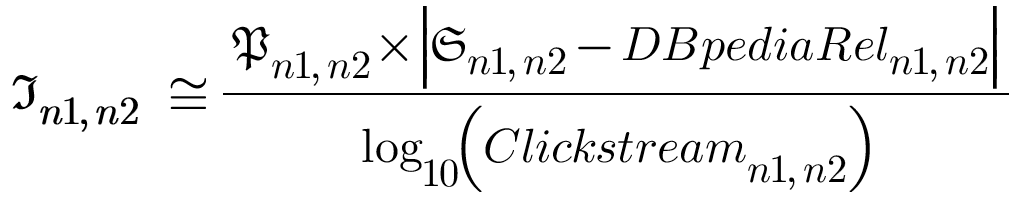

#2
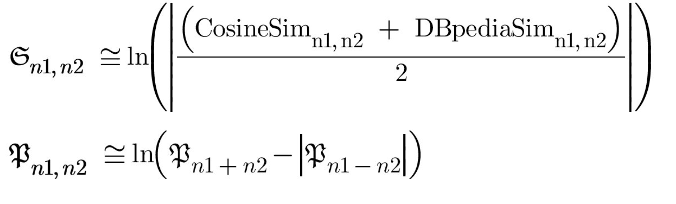


The distributional similarity between two entities is obtained through the simple average between cosine similarity (corpus-based) and DBpedia similarity (as in Sematch, concepts- or labels- based), whereas the popularity has been modelled in order to capture the following set of constraints:
1. The overall interestingness increases if both entities have a high popularity;
2. The overall interestingness increases if one entity is considerably more popular than the other;
The clickstream has been set as the denominator of the main law (2) according to the interpretation that a lower clickstream, hence a lesser obviousness of the link, shall produce a higher overall interestingness value. Once the general interestingness of every triple is computed, one can proceed on the second step of our quest: the search of most *interesting paths*.

*Extract the loose relationships from the input Knowledge Graph*

In [ ]:
import pandas as pd
import os

def filter_wikilinks(input_filename='merged_knowledge_graph_triples.csv'):
    # Construct full path
    input_path = os.path.join('/content', input_filename)

    # Read the CSV file
    print(f"Reading file from: {input_path}")
    df = pd.read_csv(input_path)

    # Filter triples with the specified predicate
    wikilink_predicate = "http://dbpedia.org/ontology/wikiPageWikiLink"
    filtered_df = df[df['predicate'] == wikilink_predicate]

    # Save filtered data to new CSV
    output_file = 'wikilinks.csv'
    output_path = os.path.join('/content', output_file)
    filtered_df.to_csv(output_path, index=False)

    # Print statistics
    print(f"\nStatistics:")
    print(f"Total triples in input: {len(df)}")
    print(f"Triples with wikiPageWikiLink: {len(filtered_df)}")
    print(f"Filtered data saved to: {output_path}")

# Run the filter function
try:
    filter_wikilinks()
    print("\nProcessing completed successfully!")
except Exception as e:
    print(f"An error occurred: {str(e)}")

Reading file from: /content/merged_knowledge_graph_triples.csv

Statistics:
Total triples in input: 1008
Triples with wikiPageWikiLink: 92
Filtered data saved to: /content/wikilinks.csv

Processing completed successfully!


*Find the retrieved Entity couples in the Wikimedia Clickstream Data Dump*

In [ ]:
!pip install numpy
!pip install tqdm

This chunk of code is much faster than the following one, which is kept only because it delivers more results. They have been saved in the file "clickstream_match.csv" and uploaded in the "content" folder.

In [ ]:
import pandas as pd
import gzip
from tqdm import tqdm
import numpy as np
import time

def preprocess_wikilinks():
    """Load and preprocess wikilinks data"""
    print("\n=== Starting Wikilinks Preprocessing ===")
    start_time = time.time()

    print("Reading wikilinks.csv...")
    wiki_df = pd.read_csv('/content/wikilinks.csv')
    print(f"Initial wikilinks shape: {wiki_df.shape}")

    print("Cleaning entity names...")
    wiki_df['subject_clean'] = wiki_df['subject'].str.replace('http://dbpedia.org/resource/', '')
    wiki_df['object_clean'] = wiki_df['object'].str.replace('http://dbpedia.org/resource/', '')

    print("Creating lookup dictionary...")
    lookup_dict = set(zip(wiki_df['subject_clean'], wiki_df['object_clean']))

    end_time = time.time()
    print(f"Wikilinks preprocessing completed in {end_time - start_time:.2f} seconds")
    print(f"Number of unique entity pairs: {len(lookup_dict)}")
    print("=== Preprocessing Complete ===\n")

    return lookup_dict

def process_clickstream_in_memory(lookup_dict):
    """Process clickstream using binary search approach"""
    matches = []
    chunk_size = 1000000
    total_rows_processed = 0
    start_time = time.time()

    print("\n=== Starting Clickstream Processing ===")
    print(f"Processing /content/clickstream-enwiki-2024-10.tsv.gz")
    print(f"Chunk size: {chunk_size:,} rows")

    try:
        # Read with minimal assumptions about the file structure
        chunks = pd.read_csv('/content/clickstream-enwiki-2024-10.tsv.gz',
                            compression='gzip',
                            sep='\t',
                            names=['prev_id', 'curr_id', 'type', 'n'],
                            on_bad_lines='skip',
                            chunksize=chunk_size)

        for chunk_num, chunk in enumerate(chunks, 1):
            chunk_start_time = time.time()
            initial_chunk_size = len(chunk)

            # Filter valid rows
            chunk = chunk[chunk['prev_id'].str.contains('^[A-Za-z0-9_]+$', na=False) &
                         chunk['curr_id'].str.contains('^[A-Za-z0-9_]+$', na=False)]

            # Check matches
            mask = chunk.apply(lambda x: (x['prev_id'], x['curr_id']) in lookup_dict, axis=1)
            matching_rows = chunk[mask]

            # Process matching rows
            for _, row in matching_rows.iterrows():
                matches.append({
                    'entity1': f"http://dbpedia.org/resource/{row['prev_id']}",
                    'entity2': f"http://dbpedia.org/resource/{row['curr_id']}",
                    'ClickstreamE1-E2': row['n']
                })

            # Update progress
            total_rows_processed += initial_chunk_size
            chunk_time = time.time() - chunk_start_time

            print(f"\nChunk {chunk_num} Statistics:")
            print(f"- Rows processed: {initial_chunk_size:,}")
            print(f"- Valid rows: {len(chunk):,}")
            print(f"- Matches found in chunk: {len(matching_rows):,}")
            print(f"- Total matches so far: {len(matches):,}")
            print(f"- Total rows processed: {total_rows_processed:,}")
            print(f"- Chunk processing time: {chunk_time:.2f} seconds")
            print(f"- Average processing speed: {initial_chunk_size/chunk_time:,.0f} rows/second")

    except Exception as e:
        print(f"\nError processing chunk: {str(e)}")
        raise

    end_time = time.time()
    total_time = end_time - start_time

    print("\n=== Clickstream Processing Complete ===")
    print(f"Total processing time: {total_time:.2f} seconds")
    print(f"Total rows processed: {total_rows_processed:,}")
    print(f"Total matches found: {len(matches):,}")
    print(f"Average processing speed: {total_rows_processed/total_time:,.0f} rows/second")

    return matches

def main():
    overall_start_time = time.time()
    print("=== Starting Knowledge Graph Matching Process ===")

    try:
        # Preprocess wikilinks
        lookup_dict = preprocess_wikilinks()

        # Process clickstream data
        matches = process_clickstream_in_memory(lookup_dict)

        # Save results
        if matches:
            print("\n=== Saving Results ===")
            print("Creating DataFrame...")
            matches_df = pd.DataFrame(matches)

            print("Writing to CSV...")
            matches_df.to_csv('/content/clickstream_matches.csv', index=False)

            print("\n=== Process Complete ===")
            print(f"Total matches found: {len(matches):,}")
            print("Results saved to: /content/clickstream_matches.csv")
        else:
            print("\nNo matches found!")

    except Exception as e:
        print(f"\nCritical error occurred: {str(e)}")

    finally:
        overall_end_time = time.time()
        total_runtime = overall_end_time - overall_start_time
        print(f"\nTotal runtime: {total_runtime:.2f} seconds ({total_runtime/60:.2f} minutes)")

if __name__ == "__main__":
    main()

=== Starting Knowledge Graph Matching Process ===

=== Starting Wikilinks Preprocessing ===
Reading wikilinks.csv...
Initial wikilinks shape: (92, 3)
Cleaning entity names...
Creating lookup dictionary...
Wikilinks preprocessing completed in 0.01 seconds
Number of unique entity pairs: 92
=== Preprocessing Complete ===


=== Starting Clickstream Processing ===
Processing /content/clickstream-enwiki-2024-10.tsv.gz
Chunk size: 1,000,000 rows

Chunk 1 Statistics:
- Rows processed: 1,000,000
- Valid rows: 210,353
- Matches found in chunk: 1
- Total matches so far: 1
- Total rows processed: 1,000,000
- Chunk processing time: 5.01 seconds
- Average processing speed: 199,756 rows/second

Chunk 2 Statistics:
- Rows processed: 1,000,000
- Valid rows: 395,277
- Matches found in chunk: 2
- Total matches so far: 3
- Total rows processed: 2,000,000
- Chunk processing time: 4.93 seconds
- Average processing speed: 202,641 rows/second

Chunk 3 Statistics:
- Rows processed: 1,000,000
- Valid rows: 402,

*Optional: no need to run. The computational cost of the following procedure is far higher, but it add some entity couples that were not retrieved through the previous computation. Estimated time: 20 minutes.*

In [ ]:
import pandas as pd
import gzip
import os
from tqdm import tqdm
import numpy as np

def load_wikilinks():
    """Load entity pairs from wikilinks.csv"""
    print("Loading wikilinks data...")
    wikilinks_df = pd.read_csv('/content/wikilinks.csv')
    # Create a set of tuples for faster lookup
    entity_pairs = set(zip(wikilinks_df['subject'], wikilinks_df['object']))
    print(f"Loaded {len(entity_pairs)} entity pairs")
    return entity_pairs

def process_clickstream(entity_pairs, chunk_size=100000):
    """Process the clickstream file using pandas chunking"""
    matches = []

    # Read the clickstream file in chunks
    print("Processing clickstream file...")
    chunks = pd.read_csv(
        '/content/clickstream-enwiki-2024-10.tsv.gz',
        compression='gzip',
        sep='\t',
        names=['prev_id', 'curr_id', 'type', 'n'],
        on_bad_lines='skip',
        chunksize=chunk_size
    )

    # Process each chunk
    for chunk in tqdm(chunks):
        # Convert to dbpedia format
        chunk['prev_id'] = 'http://dbpedia.org/resource/' + chunk['prev_id'].str.replace(' ', '_')
        chunk['curr_id'] = 'http://dbpedia.org/resource/' + chunk['curr_id'].str.replace(' ', '_')

        # Find matches in this chunk
        for _, row in chunk.iterrows():
            if (row['prev_id'], row['curr_id']) in entity_pairs:
                matches.append({
                    'entity1': row['prev_id'],
                    'entity2': row['curr_id'],
                    'ClickstreamE1-E2': row['n']
                })

        # Save intermediate results every 1M rows
        if len(matches) > 0 and len(matches) % 1000000 == 0:
            print(f"\nFound {len(matches)} matches so far...")

    return matches

def main():
    try:
        # Load entity pairs
        entity_pairs = load_wikilinks()

        # Process the file and get matches
        matches = process_clickstream(entity_pairs)

        # Save results
        if matches:
            matches_df = pd.DataFrame(matches)
            matches_df.to_csv('/content/clickstream_matches.csv', index=False)
            print(f"\nProcessing completed!")
            print(f"Total matches found: {len(matches)}")
            print("Results saved to: /content/clickstream_matches.csv")
        else:
            print("No matches found!")

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print("\nDebug information:")
        print("1. Check if both input files exist:")
        print(f"- wikilinks.csv exists: {os.path.exists('/content/wikilinks.csv')}")
        print(f"- clickstream-en-wiki.tsv.gz exists: {os.path.exists('/content/clickstream-enwiki-2024-10.tsv.gz')}")

if __name__ == "__main__":
    main()

Loading wikilinks data...
Loaded 92 entity pairs
Processing clickstream file...


348it [27:06,  4.67s/it]


Processing completed!
Total matches found: 47
Results saved to: /content/clickstream_matches.csv


The following code differs quite a lot from the project uploaded on the [WikiWooW](https://github.com/Glottocrisio/WikiWooW) Github repository because on Colab is not possible to use the last version of the library [Sematch](https://gsi-upm.github.io/sematch/), that cannot be pip-installed. This package has been my principal source for computing Knowledge- and Semantic-based Similarities, as well as the DBpedia Relatedness.
The following code makes use of a work-around solution.

In [ ]:
!pip install wikipedia
!pip install wptools

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=d8ff65b2c2da92345e240462e84a612dc9d872643fef7ca173c161cbef202c00
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 27.1 MB/s eta 0:00:00
  Created wheel for html2text: filename=html2text-2024.2.26-py3-none-any.whl size=33111 sha256=7b5291a395f9a0ff41ca3bda9cadc8d9d0dd8b294eae917fa1b647600ea5d70a
  Stored in directory: /root/.cache/pip/wheels/f3/96/6d/a7eba8f80d31cbd188a2787b81514d82fc5ae6943c44777659
Successfully built html2text


In the following, relatedness is calculated according to:

Milne, D.N., & Witten, I.H. (2008). Learning to link with wikipedia. International Conference on Information and Knowledge Management.

Relatedness(a,b) = (log(max(|A|,|B|)) - log(|A∩B|)) / (log(|W|) - log(min(|A|,|B|)))

In [ ]:
import pandas as pd
import requests
import urllib.parse, urllib.request, json
import math
import time
from SPARQLWrapper import SPARQLWrapper, JSON
from sklearn.feature_extraction.text import TfidfVectorizer
from typing import List, Dict, Tuple, Set
from collections import defaultdict
import wikipedia
import wptools

def dbpedia_similarity(entity1, entity2): # SPARQL query to find shared predicates between the two entities
    """
    Computes similarity between two Wikipedia entities using DBpedia SPARQL endpoint.

    Args:
    - entity1 (str): The first Wikipedia entity (e.g., "Barack_Obama").
    - entity2 (str): The second Wikipedia entity (e.g., "Michelle_Obama").

    Returns:
    - similarity_score (float): A similarity score between 0 and 1, or None if unavailable.
    """
    # Convert Wikipedia entities to DBpedia URIs
    base_url = "http://dbpedia.org/resource/"
    uri1 = base_url + entity1
    uri2 = base_url + entity2

    query = f"""
    PREFIX dbo: <http://dbpedia.org/ontology/>
    SELECT (COUNT(?p) AS ?commonPredicates)
    WHERE {{
        {{ <{uri1}> ?p ?o1 . }}
        {{ <{uri2}> ?p ?o2 . }}
    }}
    """

    # Send query to DBpedia endpoint
    sparql_endpoint = "https://dbpedia.org/sparql"
    params = {
        "query": query,
        "format": "application/json"
    }
    response = requests.get(sparql_endpoint, params=params)

    if response.status_code == 200:
        data = response.json()
        common_predicates = int(data['results']['bindings'][0]['commonPredicates']['value'])
        return common_predicates / 10.0  # Normalize score (arbitrary scaling factor)
    else:
        print(f"Error querying DBpedia: {response.status_code}")
        return None

def get_dbpedia_categories(entity):
    """Get categories for a DBpedia entity using SPARQL"""
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    query = f"""
    SELECT DISTINCT ?category
    WHERE {{
        <{entity}> dct:subject ?category .
    }}
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)

    try:
        results = sparql.query().convert()
        categories = [result["category"]["value"] for result in results["results"]["bindings"]]
        return set(categories)
    except Exception as e:
        return set()

def compute_dbpedia_similarity(ent1, ent2): #Approach according to intersection of categories (Jaccard similarity)
    """Compute similarity based on category overlap"""
    try:
        cats1 = get_dbpedia_categories(ent1)
        cats2 = get_dbpedia_categories(ent2)

        if not cats1 or not cats2:
            return 0.1

        intersection = len(cats1.intersection(cats2))
        union = len(cats1.union(cats2))

        if union == 0:
            return 0.1
        return round(intersection / union, 2)
    except:
        return 0.1

def dbpedia_relatedness(ent1, ent2):
    """Compute relatedness based on category overlap and depth"""
    try:
        cats1 = get_dbpedia_categories(ent1)
        cats2 = get_dbpedia_categories(ent2)

        if not cats1 or not cats2:
            return 0

        # Weighted overlap considering category depth
        intersection = cats1.intersection(cats2)
        if not intersection:
            return 0

        # Simple logarithmic scaling based on number of shared categories
        return round(math.log(1 + len(intersection)) / math.log(10), 2)
    except:
        return 0

def get_linking_articles(entity: str) -> Set[str]:
    """
    Get all articles that link to the given entity from DBpedia.

    Args:
        entity (str): The DBpedia entity URI (e.g., "http://dbpedia.org/resource/Some_Entity").

    Returns:
        Set[str]: A set of URIs for articles linking to the given entity.
    """
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")

    # SPARQL query to fetch linking articles
    query = f"""
    SELECT DISTINCT ?article WHERE {{
        ?article dbo:wikiPageWikiLink <{entity}> .
    }}
    """
    try:
        sparql.setQuery(query)
        sparql.setReturnFormat(JSON)  # Ensure the response is in JSON format
        results = sparql.query().convert()  # Convert the response to JSON

        # Extract results into a set
        linking_articles = set()
        for result in results["results"]["bindings"]:
            article = result["article"]["value"]
            linking_articles.add(article)

        return linking_articles

    except Exception as e:
        print(f"Error fetching linking articles for {entity}: {e}")
        return set()

def calculate_relatedness(entity1: str, entity2: str) -> float:
    """
    Calculate Wikipedia relatedness using the formula:
    relatedness(a,b) = (log(max(|A|,|B|)) - log(|A∩B|)) / (log(|W|) - log(min(|A|,|B|)))

    Where:
    - A and B are sets of articles linking to entity1 and entity2
    - W is the total number of articles in Wikipedia
    """
    try:
        # Get linking articles for both entities
        A = get_linking_articles(entity1)
        B = get_linking_articles(entity2)

        if not A or not B:
            return 0.0

        # Calculate components of the formula
        max_links = max(len(A), len(B))
        min_links = min(len(A), len(B))
        intersection = len(A.intersection(B))

        # Handle edge cases
        if intersection == 0 or min_links == 0:
            return 0.0

        # Calculate relatedness using the formula
        numerator = math.log(max_links) - math.log(intersection)
        denominator = math.log(6500000) - math.log(min_links) #6500000 is the number of articles in wikipedia

        if denominator == 0:
            return 0.0

        relatedness = numerator / denominator

        # Normalize to [0,1] range and invert (since original formula gives distance rather than similarity)
        relatedness = 1 - min(1, max(0, relatedness))

        return relatedness

    except Exception as e:
        print(f"Error calculating relatedness: {e}")
        return 0.0

def WikifierPageRank(entity):
    """Get PageRank from Wikifier"""
    try:
        data = urllib.parse.urlencode([
            ("text", entity), ("lang", "en"),
            ("userKey", "mjxwdfdvrjmgkrlimhzkoumetmkacy"),
            ("pageRankSqThreshold", "0.6"), ("applyPageRankSqThreshold", "false"),
            ("nTopDfValuesToIgnore", "200"), ("nWordsToIgnoreFromList", "200"),
            ("wikiDataClasses", "true"), ("wikiDataClassIds", "true"),
            ("support", "true"), ("ranges", "true"), ("minLinkFrequency", "2"),
            ("includeCosines", "true"), ("maxMentionEntropy", "3")
        ])
        url = "http://www.wikifier.org/annotate-article"
        req = urllib.request.Request(url, data=data.encode("utf8"), method="POST")
        with urllib.request.urlopen(req, timeout=60) as f:
            response = json.loads(f.read().decode("utf8"))

        if len(response.get('annotations', [])) > 0:
            return round(float(response['annotations'][0]['pageRank']), 2) + 1
        return 1
    except Exception:
        return 1

def singleclickstream(entity):
    """Get clickstream data for entity"""
    headers = {'User-Agent': 'ISAAKx/1.0'}
    url = f'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/{entity}/monthly/20181101/20181130'

    try:
        resp = requests.get(url, headers=headers)
        if resp.status_code == 200:
            return int(resp.json()['items'][0]['views'])
    except Exception:
        pass
    return 1

def entpopularity(entity):
    """Calculate entity popularity"""
    clicks = singleclickstream(entity)
    if clicks > 1 and WikifierPageRank(entity) > 1:
        return round(clicks/WikifierPageRank(entity), 2)
    elif clicks > 100:
        return round(clicks/3, 2)
    return 0

def CosineSimilarity(title1, title2):
    """Calculate cosine similarity between entities"""
    try:
        title1 = title1.replace(" ","").replace("_"," ").replace("'","")
        title2 = title2.replace(" ","").replace("_"," ").replace("'","")
        data = urllib.parse.urlencode([("lang", "en"), ("title1", title1), ("title2", title2)])
        url = "http://www.wikifier.org/get-cosine-similarity?" + data
        with urllib.request.urlopen(url, timeout=60) as f:
            response = json.loads(f.read().decode("utf8"))
            return round(response["cosTfIdfVec"], 2)
    except Exception:
        return 0

def calculate_metrics(df):
    """Calculate all metrics for the dataset"""
    print("Processing metrics for each row...")

    enhanced_data = []

    total_rows = len(df)
    for idx, row in df.iterrows():
        if idx % 10 == 0:
            print(f"Processing row {idx}/{total_rows}")

        ent1 = row['entity1'].replace('http://dbpedia.org/resource/', '')
        ent2 = row['entity2'].replace('http://dbpedia.org/resource/', '')

        # Calculate popularities
        pop_e1 = entpopularity(ent1)
        pop_e2 = entpopularity(ent2)
        pop_diff = abs(pop_e1 - pop_e2)
        pop_sum = pop_e1 + pop_e2

        # Calculate similarities
        cos_sim = CosineSimilarity(ent1, ent2)
        dbpedia_sim = dbpedia_similarity(row['entity1'], row['entity2'])
        if dbpedia_sim == 0:
            dbpedia_sim = compute_dbpedia_similarity(row['entity1'], row['entity2'])

        dbpedia_rel = calculate_relatedness(row['entity1'], str(row['entity2']))

        # Calculate Palma interestingness
        if pop_sum > 0:
            pop = math.log(pop_sum + pop_diff) + 1
            csim = math.log((cos_sim + dbpedia_sim)/2 + 0.1)
            ksim = math.log(dbpedia_rel + 0.1)
            palma_int = round((pop * abs(csim - ksim))/math.log10(row['ClickstreamE1-E2'] + 1), 2)
        else:
            palma_int = 0

        enhanced_data.append({
            'Entity1': row['entity1'],
            'Entity2': row['entity2'],
            'ClickstreamEnt1-Ent2': row['ClickstreamE1-E2'],
            'PopularityEnt1': pop_e1,
            'PopularityEnt2': pop_e2,
            'PopularityDiff': pop_diff,
            'PopularitySum': pop_sum,
            'CosineSimilarityEnt1Ent2': cos_sim,
            'DBpediaSimilarityEnt1Ent2': dbpedia_sim,
            'DBpediaRelatednessEnt1Ent2': dbpedia_rel,
            'PalmaInterestingnessEnt1Ent2': palma_int
        })

        # Sleep briefly to avoid hitting API limits
        time.sleep(0.1)

    return pd.DataFrame(enhanced_data)

def main():
    print("Loading initial dataset...")
    # Load your clickstream matches
    df = pd.read_csv('/content/clickstream_matches.csv')

    # Calculate metrics
    enhanced_df = calculate_metrics(df)

    # Save results
    print("Saving enhanced dataset...")
    enhanced_df.to_csv('/content/enhanced_matches.csv', index=False, sep=',')
    print("Processing complete!")

if __name__ == "__main__":
    main()

Loading initial dataset...
Processing metrics for each row...
Processing row 0/40
Processing row 10/40
Processing row 20/40
Processing row 30/40
Saving enhanced dataset...
Processing complete!


Sorting the entity pairs in the outputted .csv file by descending Interestingness score, should provide a glimpse of the most interesting couples, that can be included in the Narrative Knowledge Graph and whose relationship can be deepen by automatic or analogical methods.

The proposed pipeline is a lightweight version of the main one, stored in the GitHub Repository [WikiWooW](https://github.com/Glottocrisio/WikiWooW).

For referencing this work in scientific publication, refer to the preprint:

Palma C., The WikiWooW Dataset - Harnessing Semantic Similarity and Clickstream-data for Serendipity-based Relation Discovery in Wikipedia, 10.13140/RG.2.2.23757.76009